In [2]:
import os, io
from pathlib import Path
import math
from collections import defaultdict, Counter, deque
from heapq import heapify, heappush, heappop
from itertools import chain
from dataclasses import dataclass, field
import itertools
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from scipy.interpolate import RegularGridInterpolator

from utils import *
from hdc import *

In [3]:
LOG = Logging()

config_var = 'SQLITE3_VECTOR_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = numpy


In [4]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

def drop_table_safe(db_con, tn):
    if is_table_exists(db_con, tn):
        db_con.cursor().execute(f'DROP TABLE {tn}')
        db_con.commit()

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(get_full_db_file_name(config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name), autocommit=False)

# Load MNIST

In [5]:
dataset_source = os.path.join(config.dataset_source)

In [6]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 171 ms, sys: 67.9 ms, total: 239 ms
Wall time: 238 ms


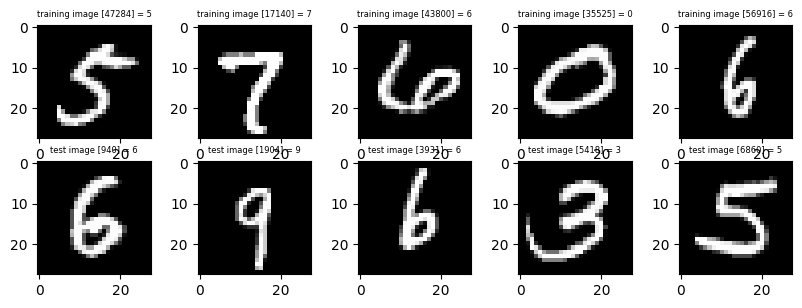

In [7]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Sensor

In [8]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE ** 2

SENSORS_COUNT = config.sensors_count
SENSORS_COUNT_ROOT = int(np.sqrt(SENSORS_COUNT))
assert SENSORS_COUNT_ROOT ** 2 == SENSORS_COUNT
assert SENSORS_COUNT_ROOT > 1


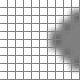
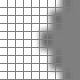
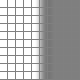
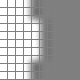
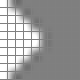
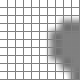
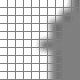
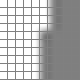
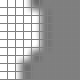
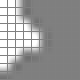
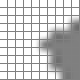
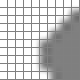
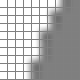
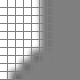
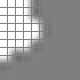
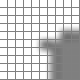
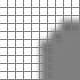
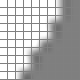
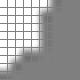
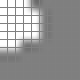

In [9]:
SENSOR_STATES_INFO = defaultdict(list)
SENSOR_STATES_IMG = []
sz = SENSOR_RECEPTIVE_FIELD_SIZE
captions = []

assert config.encoding_type == 'vector'

angle_step = 10 # degrees
angles = list(range(0, 360, angle_step)) + [45 * 1, 45 * 3, 45 * 5, 45 * 7]
angles = sorted(angles)
# sweeps = [50, 90, 130, 180, 230, 270, 310] # for receptive field size = 8 more finer sweeps make little sense 
sweeps = [90, 130, 180, 230, 270] # for receptive field size = 8 more finer sweeps make little sense 

for angle in angles:
    # for sweep in range(angle_step, 180 + angle_step, angle_step):
    for sweep in sweeps:
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.rectangle([0, 0, sz, sz], fill=127, outline=127)
        piesclice_angle1 = angle + sweep // 2
        piesclice_angle2 = angle - sweep // 2
        draw.pieslice([-sz, -sz, sz * 2 - 1, sz * 2 - 1], start=piesclice_angle1, end=piesclice_angle2, fill=255, outline=255, width=0)
        captions.append(f'ang={angle}, swp={sweep} ')
        SENSOR_STATES_IMG.append(canvas)
        SENSOR_STATES_INFO['normal'].append(angle)
        SENSOR_STATES_INFO['sweep'].append(sweep)
        SENSOR_STATES_INFO['normal_vec'].append(np.exp((1j) * np.radians(angle)))
        SENSOR_STATES_INFO['sweep1_vec'].append(np.exp((1j) * np.radians(piesclice_angle1)))
        SENSOR_STATES_INFO['sweep2_vec'].append(np.exp((1j) * np.radians(piesclice_angle2)))

SENSOR_STATES_INFO = pd.DataFrame(SENSOR_STATES_INFO)
assert len(SENSOR_STATES_INFO) == len(SENSOR_STATES_IMG)
n_to_show = len(sweeps) * 4
images_to_show = list(map(lambda x: lay_grid(x.resize((80, 80)), 8), SENSOR_STATES_IMG[:n_to_show]))
display_images_grid(images_to_show, captions=captions[:n_to_show], col_count=len(sweeps) )

In [10]:
SENSOR_STATES_INFO.head()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
0,0,90,1.0+0.0j,0.707107+0.707107j,0.707107-0.707107j
1,0,130,1.0+0.0j,0.422618+0.906308j,0.422618-0.906308j
2,0,180,1.0+0.0j,0.000000+1.000000j,0.000000-1.000000j
3,0,230,1.0+0.0j,-0.422618+0.906308j,-0.422618-0.906308j
4,0,270,1.0+0.0j,-0.707107+0.707107j,-0.707107-0.707107j


In [11]:
SENSOR_STATES_INFO.tail()

,normal,sweep,normal_vec,sweep1_vec,sweep2_vec
195,350,90,0.984808-0.173648j,0.819152+0.573576j,0.573576-0.819152j
196,350,130,0.984808-0.173648j,0.573576+0.819152j,0.258819-0.965926j
197,350,180,0.984808-0.173648j,0.173648+0.984808j,-0.173648-0.984808j
198,350,230,0.984808-0.173648j,-0.258819+0.965926j,-0.573576-0.819152j
199,350,270,0.984808-0.173648j,-0.573576+0.819152j,-0.819152-0.573576j


In [12]:
# Turn grayscale images of sensor states to numpy arrays with weights which balance positive and negative areas
SENSOR_STATES = np.array(list(map(np.array, SENSOR_STATES_IMG))).astype(float)
SENSOR_STATES = SENSOR_STATES.reshape(-1, SENSOR_RECEPTIVE_FIELD_SIZE ** 2)
SENSOR_STATES[SENSOR_STATES == 255] = 1
SENSOR_STATES[SENSOR_STATES == 127] = -1
assert set(np.unique(SENSOR_STATES)) == set([-1, +1])

SENSOR_STATES_COUNT = SENSOR_STATES.shape[0]
SENSOR_STATES.shape, np.unique_counts(SENSOR_STATES)

((200, 64),
 UniqueCountsResult(values=array([-1.,  1.]), counts=array([5942, 6858])))

In [13]:
SENSOR_STATE_AREAS_POS = (SENSOR_STATES == 1).sum(axis=1) 
SENSOR_STATE_AREAS_NEG = (SENSOR_STATES == -1).sum(axis=1)
assert np.all(SENSOR_STATE_AREAS_POS > 0)
assert np.all(SENSOR_STATE_AREAS_NEG > 0)
SENSOR_STATE_AREAS_POS.shape, SENSOR_STATE_AREAS_POS.mean(), SENSOR_STATE_AREAS_POS.std(), \
SENSOR_STATE_AREAS_NEG.shape, SENSOR_STATE_AREAS_NEG.mean(), SENSOR_STATE_AREAS_NEG.std()

((200,),
 np.float64(34.29),
 np.float64(11.739075772819596),
 (200,),
 np.float64(29.71),
 np.float64(11.739075772819596))

In [14]:
SENSOR_STATES_POS = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_NEG = xp_array_to_gpu_copy(SENSOR_STATES)
SENSOR_STATES_POS[SENSOR_STATES_POS < 0] = 0
SENSOR_STATES_NEG[SENSOR_STATES_NEG > 0] = 0

In [15]:
np.unique_counts(SENSOR_STATES_POS),np.unique_counts(SENSOR_STATES_NEG)

(UniqueCountsResult(values=array([0., 1.]), counts=array([5942, 6858])),
 UniqueCountsResult(values=array([-1.,  0.]), counts=array([5942, 6858])))

# Retina

In [16]:
class SensorLayoutMaker(object):
    def __call__(self, sensor_index):
        return None

class SensorLayoutMaker_Grid(SensorLayoutMaker):
    def __init__(self):
        self.s = SENSORS_COUNT_ROOT
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZE
        space_for_sensors = self.s * self.field_size 
        self.dist_between_sensors = (config.sample_size - space_for_sensors) / (self.s - 1)
        
    def __call__(self, sensor_index):
        x = int((sensor_index % self.s) * (self.field_size + self.dist_between_sensors))
        y = int((sensor_index // self.s) * (self.field_size + self.dist_between_sensors))
        # adjust to fit into boundaries
        x -= max(0, (x + self.field_size) - config.sample_size) 
        y -= max(0, (y + self.field_size) - config.sample_size)
        return x, y, self.field_size

In [17]:
SENSOR_LAYOUT_MAKER = None

match config.retina_layout:
    case 'grid': 
        SENSOR_LAYOUT_MAKER = SensorLayoutMaker_Grid()
    case _:
        assert False, config.retina_layout

In [18]:
assert not SENSOR_LAYOUT_MAKER is None
SENSOR_INSTANCES_INFO = pd.DataFrame(columns=['x_offset', 'y_offset', 'size', 'bounds_rect', 'x_center', 'y_center', 'radius'])

for i in range(SENSORS_COUNT):
    x_offset, y_offset, field_size = SENSOR_LAYOUT_MAKER(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    SENSOR_INSTANCES_INFO.loc[len(SENSOR_INSTANCES_INFO)] = [
        x_offset,
        y_offset,
        field_size,
        [x_offset, y_offset, x_offset + field_size - 1, y_offset + field_size - 1],
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

SENSOR_INSTANCES_INFO

,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,0,0,8,"[0, 0, 7, 7]",4,4,4
1,1,0,8,"[1, 0, 8, 7]",5,4,4
2,3,0,8,"[3, 0, 10, 7]",7,4,4
3,5,0,8,"[5, 0, 12, 7]",9,4,4
4,7,0,8,"[7, 0, 14, 7]",11,4,4
...,...,...,...,...,...,...,...
4091,112,120,8,"[112, 120, 119, 127]",116,124,4
4092,114,120,8,"[114, 120, 121, 127]",118,124,4
4093,116,120,8,"[116, 120, 123, 127]",120,124,4
4094,118,120,8,"[118, 120, 125, 127]",122,124,4


CPU times: user 101 ms, sys: 83 μs, total: 101 ms
Wall time: 101 ms


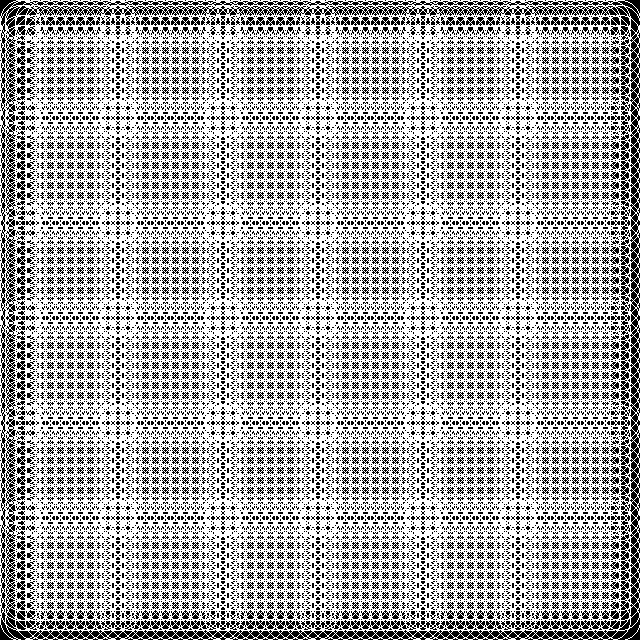

In [19]:
%%time
sz = config.sample_size
k = 5
retina_map_image = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map_image)

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    center_x = k * row.x_center
    center_y = k * row.y_center
    radius = k * row.radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

retina_map_image

In [20]:
SENSOR_PATCH_COORDS = []

for _, row in SENSOR_INSTANCES_INFO.iterrows():
    x_offset = row.x_offset
    y_offset = row.y_offset
    size = row['size']

    for i in range(size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + size)
        SENSOR_PATCH_COORDS.append(stride_coords)

SENSOR_PATCH_COORDS = np.array(SENSOR_PATCH_COORDS)

In [21]:
def get_image_patches_for_sensor_groups(images_matrix):
    assert images_matrix.ndim == 2, images_matrix.ndim
    assert images_matrix.shape[1] == config.sample_size ** 2, images_matrix.shape[1]
    images_count = images_matrix.shape[0]
    # Result is 3d-tensor: 1 dim - image, 2 dim - patch no, 3 dim - patch itself (pixels)
    return np.take(images_matrix, SENSOR_PATCH_COORDS, axis=1).reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE)

# sense_images

In [22]:
a = np.arange(16).reshape(4,4)
a2 = a * (-2)
a2[3] += 1
a, a2

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([[  0,  -2,  -4,  -6],
        [ -8, -10, -12, -14],
        [-16, -18, -20, -22],
        [-23, -25, -27, -29]]))

In [23]:
# Get patches 2x2 from upper left and bottom right corners of both a and a2
x = np.take(np.vstack([a.ravel(), a2.ravel()]), [[0, 1], [4, 5], [10, 11], [14, 15]], axis=1).reshape(2, -1, 4)
x

array([[[  0,   1,   4,   5],
        [ 10,  11,  14,  15]],

       [[  0,  -2,  -8, -10],
        [-20, -22, -27, -29]]])

In [24]:
# Get mean of each patch
x.mean(axis=2)

array([[  2.5,  12.5],
       [ -5. , -24.5]])

In [25]:
# Recalculate patches against their mean and turn to shape: images(2), patches(2), pixels(4)
y = x.reshape(-1, 4).T - x.mean(axis=2).ravel()
y.T.reshape(2, -1, 4).transpose(0, 2, 1)

array([[[-2.5, -2.5],
        [-1.5, -1.5],
        [ 1.5,  1.5],
        [ 2.5,  2.5]],

       [[ 5. ,  4.5],
        [ 3. ,  2.5],
        [-3. , -2.5],
        [-5. , -4.5]]])

In [26]:
image = np.empty((config.sample_size, config.sample_size), dtype='b')
image2 = np.empty((config.sample_size, config.sample_size), dtype='b')
images_matrix = np.vstack([image.ravel(), image2.ravel()])
images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_groups(images_matrix)
images_patches.shape

(2, 4096, 64)

In [27]:
mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_luminiscene_in_patches.shape

(2, 4096)

In [28]:
images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
images_patches = images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
images_patches.shape

(2, 64, 4096)

In [102]:
images = []

for _ in range(1):
    image_index = RNG.choice(len(x_train))
    # image_index = 58980 # 4 with isthmus
    # image_index = 38174 # 3 with isthmus
    # image_index = 4900 # 1 unclosed right side
    print(image_index)
    img_data = x_train[image_index]
    
    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        img = img.resize((config.sample_size, config.sample_size))
        images.append(np.array(img).ravel())

images_matrix = xp_array_to_gpu(np.vstack([images]))

35616


In [103]:
%%time
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9

images_count = images_matrix.shape[0]
images_patches = get_image_patches_for_sensor_groups(images_matrix) # array of matrices: image no -> matrix with patches as row vectors

mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
mean_images_patches = images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
# mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors

images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
assert images_patches.shape == mean_images_patches.shape

abs_illum_level_pos = (SENSOR_STATES_POS @ images_patches).transpose(0, 2, 1)
abs_illum_level_neg = (SENSOR_STATES_NEG @ images_patches).transpose(0, 2, 1)
rel_illum_level_pos = (SENSOR_STATES_POS @ xp.where(mean_images_patches > 0, +1, 0)).transpose(0, 2, 1) # for +/- tallying
rel_illum_level_neg = (SENSOR_STATES_NEG @ xp.where(mean_images_patches < 0, -1, 0)).transpose(0, 2, 1)  # for +/- tallying

assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_STATES_COUNT), abs_illum_level_pos.shape
assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
assert rel_illum_level_neg.shape == abs_illum_level_pos.shape

sense_vectors = []
# For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) state.
# If we have some state (say some angle and some sweep), what is condition that given patch corresponds to this state?
# Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by situation
# when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
# like this is the reason why we don't hear very low frequencies or don't percieve low light - becase ratio get oversaturaed very quickly.
# But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
# and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
# To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
# To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
# absolute illumination on positive and negative part
for ailp_i, ailn_i, rilp_i, riln_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg): # Per image cycle
    # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor states)
    shape_save = ailp_i.shape

    # MAC {0, 1}
    # Illumination level on positive area must exceed lower threshold (sensor must be somewhat illuminated)
    # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's state
    abs_illumination_scores = ailp_i > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_STATE_AREAS_POS

    # MAC {0, 1}
    # Illumination level on positive part must distinguishably exceed illumination level of negative part
    ailn_i += 1e-6 # to get rid of possible division by zero errors
    ailp_i = ailp_i / SENSOR_STATE_AREAS_POS
    ailn_i = ailn_i / SENSOR_STATE_AREAS_NEG
    diff_abs_illumination_scores = xp.abs(ailp_i.ravel() / ailn_i.ravel())
    diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
    # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative
    diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)

    # Score {0, [MINIMAL_PLUS_MINUS_DISTR_REL_DIFF...1]}
    # Tally concentration of +/- pixels on positive/negative side and compare against theirs areas. 
    # For sensors with proper distribution ratio will be around 1 for each of the scores.
    # *concentration_scores = matrix of N(patches count), columns - [0...1] how well pixels in patch are distributed according to given sensor's state
    pluses_concentration_scores = rilp_i / SENSOR_STATE_AREAS_POS
    assert xp.all((pluses_concentration_scores >= 0) & (pluses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (pluses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    pluses_concentration_scores = xp.where(mask, 0, pluses_concentration_scores)

    minuses_concentration_scores = riln_i / SENSOR_STATE_AREAS_NEG
    assert xp.all((minuses_concentration_scores >= 0) & (minuses_concentration_scores <= 1)) # comment for production (to speed up)
    mask = (minuses_concentration_scores < MINIMAL_PLUS_MINUS_DISTR_REL_DIFF)
    minuses_concentration_scores = xp.where(mask, 0, minuses_concentration_scores)
    
    # sense_matrix = matrix of N(patches count), columns - 0/1 if all three conditions meet for given sensor state
    sense_matrix = (abs_illumination_scores.astype(float) + diff_abs_illumination_scores.astype(float) + pluses_concentration_scores + minuses_concentration_scores)
    min_score = 1 + 1 + (MINIMAL_PLUS_MINUS_DISTR_REL_DIFF * 2)
    sense_vector = xp.where(xp.any(sense_matrix > min_score, axis=1), xp.argmax(sense_matrix, axis=1), -1)
    sense_vectors.append(sense_vector)

sense_vectors = xp.vstack(sense_vectors)

CPU times: user 838 ms, sys: 0 ns, total: 838 ms
Wall time: 78.5 ms


In [104]:
assert sense_vector.shape[0] == len(SENSOR_INSTANCES_INFO)
sensor_instance_inds = np.argwhere(sense_vector != -1).ravel()
sensor_state_inds = np.take(sense_vector, sensor_instance_inds)
assert sensor_instance_inds.shape[0] == sensor_state_inds.shape[0]
df_sensor_instances_raw = pd.DataFrame({'sensor_instance_ind': sensor_instance_inds, 'sensor_state_ind': sensor_state_inds})
df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_STATES_INFO, how='left', left_on='sensor_state_ind', right_index=True)
df_sensor_instances_raw = df_sensor_instances_raw.merge(SENSOR_INSTANCES_INFO, how='left', left_on='sensor_instance_ind', right_index=True)
df_sensor_instances_raw

,sensor_instance_ind,sensor_state_ind,normal,sweep,normal_vec,sweep1_vec,sweep2_vec,x_offset,y_offset,size,bounds_rect,x_center,y_center,radius
0,478,134,230,270,-0.642788-0.766044j,0.996195+0.087156j,-0.087156+0.996195j,57,13,8,"[57, 13, 64, 20]",61,17,4
1,479,139,240,270,-0.500000-0.866025j,0.965926+0.258819j,-0.258819+0.965926j,59,13,8,"[59, 13, 66, 20]",63,17,4
2,480,143,250,230,-0.342020-0.939693j,0.996195+0.087156j,-0.707107+0.707107j,60,13,8,"[60, 13, 67, 20]",64,17,4
3,481,148,260,230,-0.173648-0.984808j,0.965926+0.258819j,-0.819152+0.573576j,62,13,8,"[62, 13, 69, 20]",66,17,4
4,482,164,290,270,0.342020-0.939693j,0.422618+0.906308j,-0.906308+0.422618j,64,13,8,"[64, 13, 71, 20]",68,17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,3617,43,70,230,0.342020+0.939693j,-0.996195-0.087156j,0.707107-0.707107j,62,106,8,"[62, 106, 69, 113]",66,110,4
446,3618,33,50,230,0.642788+0.766044j,-0.965926+0.258819j,0.422618-0.906308j,64,106,8,"[64, 106, 71, 113]",68,110,4
447,3619,19,30,270,0.866025+0.500000j,-0.965926+0.258819j,-0.258819-0.965926j,66,106,8,"[66, 106, 73, 113]",70,110,4
448,3678,64,110,270,-0.342020+0.939693j,-0.422618-0.906308j,0.906308-0.422618j,57,108,8,"[57, 108, 64, 115]",61,112,4


In [105]:
altitude_map_lores = np.zeros((config.sample_size, config.sample_size))

for _, si in df_sensor_instances_raw.iterrows():
    sensor_state = SENSOR_STATES[si.sensor_state_ind]
    size = si['size']
    altitude_map_lores[si.y_offset:si.y_offset + size, si.x_offset:si.x_offset + size] += sensor_state.reshape(size, size)

altitude_map_lores = altitude_map_lores.astype('i')

In [106]:
%%time
altitude_extend_by = 5 # number of new intermediate cells for each side of 2x2 rect, e.g. 3x3 becomes 13x13 if altitude_extend_by is 5
altitude_lores_to_hires_translate_factor = (altitude_extend_by + 1)
altitude_map_hires_size = (config.sample_size - 1) * altitude_lores_to_hires_translate_factor + 1
altitude_map_hires = np.zeros((altitude_map_hires_size, altitude_map_hires_size), dtype='f')
patch_hires_shape = (2 + altitude_extend_by, 2 + altitude_extend_by)
ii, jj = np.mgrid[0:patch_hires_shape[0], 0:patch_hires_shape[1]]
patch_hires_indices = np.array(list(zip(ii.ravel(), jj.ravel())))

for i in range(altitude_map_lores.shape[0] - 1):
    for j in range(altitude_map_lores.shape[1] - 1):
        patch = altitude_map_lores[i:i+2, j:j+2].astype(float)

        if np.any(patch != 0):
            interp = RegularGridInterpolator(([0, patch_hires_shape[0] - 1], [0, patch_hires_shape[1] - 1]), patch)
            patch_hires = interp(patch_hires_indices).reshape(patch_hires_shape)
        else:
            patch_hires = 0
            
        i_hires = i * altitude_lores_to_hires_translate_factor
        j_hires = j * altitude_lores_to_hires_translate_factor
        altitude_map_hires[i_hires:i_hires+patch_hires_shape[0], j_hires:j_hires+patch_hires_shape[1]] = patch_hires

CPU times: user 241 ms, sys: 2.68 ms, total: 243 ms
Wall time: 242 ms



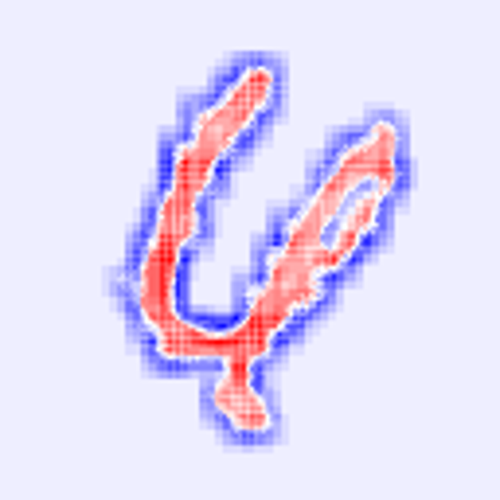
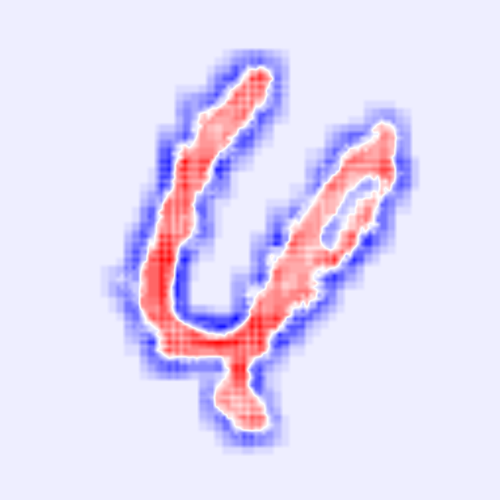

In [107]:
altitude_color_map = mpl.colormaps['bwr']
altitude_images = []
altitude_maps = [altitude_map_lores, altitude_map_hires]

for am in altitude_maps:
    image_pil = Image.new('RGB', size=(am.shape[0], am.shape[1]))
    draw = ImageDraw.Draw(image_pil)
    min_max_scaler = preprocessing.MinMaxScaler()
    altitude_map_scaled = min_max_scaler.fit_transform(am.reshape(-1, 1)).reshape(am.shape)

    for y in range(am.shape[0]):
        for x in range(am.shape[1]):
            color = altitude_color_map(altitude_map_scaled[y, x], bytes=True)
            draw.point((x, y), fill=color)

    altitude_images.append(image_pil)
    
display_images(list(map(lambda i: i.resize((500, 500)), altitude_images)))

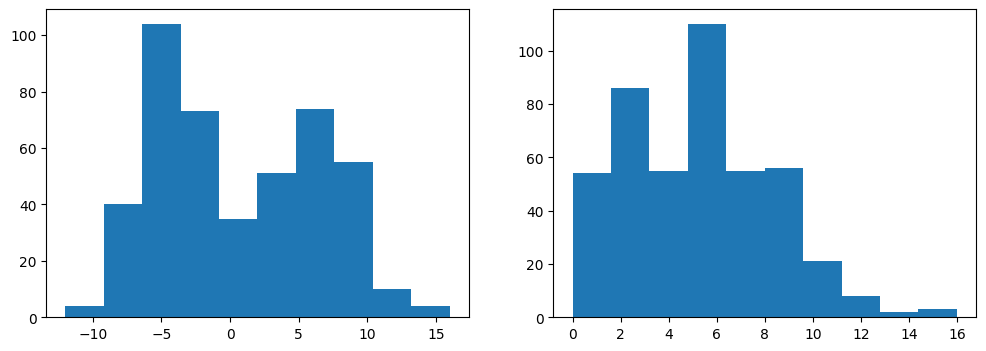

In [108]:
altitudes_lores = []
altitudes_hires = []

for _, si in df_sensor_instances_raw.iterrows():
    altitudes_lores.append(altitude_map_lores[si.y_center, si.x_center])

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.hist(altitudes_lores)

plt.subplot(1, 2, 2)
plt.hist(np.abs(altitudes_lores))
plt.show()

In [109]:
landed_centers = defaultdict(list)

for _, si in df_sensor_instances_raw.iterrows():
    x_center_land = si.x_center * altitude_lores_to_hires_translate_factor
    y_center_land = si.y_center * altitude_lores_to_hires_translate_factor
    altitude = altitude_map_hires[y_center_land, x_center_land]

    if np.abs(altitude) > 1:
        travel_point = complex(x_center_land, y_center_land)
        direction = -1 if altitude < 0 else +1
        
        for i in range(100):
            travel_point += direction * si.normal_vec
            new_x_center_land = np.round(travel_point.real, decimals=0).astype(int)
            new_y_center_land = np.round(travel_point.imag, decimals=0).astype(int)
            new_altitude = np.abs(altitude_map_hires[new_y_center_land, new_x_center_land])

            if new_altitude <= altitude:
                altitude = new_altitude
                x_center_land = new_x_center_land
                y_center_land = new_y_center_land
            else:
                break
        else:
            assert False

    landed_centers['x_center_new'].append(x_center_land)
    landed_centers['y_center_new'].append(y_center_land)
    landed_centers['x_center_orig'].append(int(x_center_land / altitude_lores_to_hires_translate_factor))
    landed_centers['y_center_orig'].append(int(y_center_land / altitude_lores_to_hires_translate_factor))
    landed_centers['altitude_new'].append(altitude)

df_sensor_instances = df_sensor_instances_raw.copy()

for col_name, values in landed_centers.items():
    df_sensor_instances[col_name] = values

df_sensor_instances.drop(['x_center', 'y_center', 'x_offset', 'y_offset', 'bounds_rect', 'normal_vec', 'sweep1_vec', 'sweep2_vec', 'size'], axis=1, inplace=True)
df_sensor_instances.rename({'x_center_new': 'x_center', 'y_center_new': 'y_center', 'altitude_new': 'altitude'}, axis=1, inplace=True, errors='raise')
df_sensor_instances = df_sensor_instances.loc[np.abs(df_sensor_instances.altitude) < 3]
df_sensor_instances['x'] = 'x'
df_sensor_instances

,sensor_instance_ind,sensor_state_ind,normal,sweep,radius,x_center,y_center,x_center_orig,y_center_orig,altitude,x
1,479,139,240,270,4,378,102,63,17,-1.000000,x
3,481,148,260,230,4,396,102,66,17,1.000000,x
7,543,133,230,230,4,375,110,62,18,0.166667,x
8,546,178,315,230,4,412,110,68,18,0.111111,x
12,607,137,240,180,4,371,114,61,19,0.166667,x
...,...,...,...,...,...,...,...,...,...,...,...
433,3421,72,130,180,4,346,634,57,105,0.777778,x
437,3486,67,120,180,4,358,650,59,108,0.222222,x
438,3549,78,135,230,4,354,648,59,108,-2.000000,x
439,3551,67,120,180,4,374,656,62,109,0.555556,x


In [110]:
sensor_instance_map = {}

for _, si in df_sensor_instances.iterrows():
    sensor_instance_map[si.y_center, si.x_center] = si

In [111]:

# pts = np.array(list(wave_front_touched))
# plt.ylim(0, altitude_map_hires.shape[0])
# plt.xlim(0, altitude_map_hires.shape[0])
# plt.scatter(pts[:,1], altitude_map_hires.shape[0] - pts[:,0])
# plt.show()

In [112]:
%%time
WAVE_FRONT_LENGTH_LIMIT = 500 # to prevent breaches

# choose random sensor instance to start from
start_sensor_inst_index = RNG.choice(df_sensor_instances.index)
start_sensor_inst = df_sensor_instances.loc[start_sensor_inst_index]
assert start_sensor_inst.altitude < 3

wave_front_que = deque([(int(start_sensor_inst.y_center), int(start_sensor_inst.x_center))])
wave_front_lengths = defaultdict(int) # key - sensor_instance_ind, value - number of points as a length 

wave_front_map = np.full_like(altitude_map_hires, -1, dtype='i')
wave_front_map[wave_front_que[0]] = start_sensor_inst.name

wave_front_touched = set([wave_front_que[0]])

sensor_inst_chains = {} # key - last element in chain of sensor instances, value - chain itself

while wave_front_que:
    # Visit point on top of the wave_front
    wave_front_point = wave_front_que.popleft()
    wave_front_sensor_inst_ind = wave_front_map[wave_front_point]
    wave_front_map[wave_front_point] = -1
    assert wave_front_sensor_inst_ind > -1
    LOG(f'Visiting {wave_front_point} (si={wave_front_sensor_inst_ind}) (of {len(wave_front_que)})')

    si = sensor_instance_map.get(wave_front_point, None)

    if not si is None and si.name != wave_front_sensor_inst_ind:
        # New sensor instance discovered! Link with the previous one, ...
        sensor_inst_chain = sensor_inst_chains.pop(wave_front_sensor_inst_ind, [wave_front_sensor_inst_ind])
        sensor_inst_chain.append(si.name)
        assert not si.name in sensor_inst_chains, f'{si.name} in sensor_inst_chains'
        sensor_inst_chains[si.name] = sensor_inst_chain
        
        LOG(f'New si encountered: {si.name}, linked after {wave_front_sensor_inst_ind}')
        wave_front_sensor_inst_ind = si.name
        # ... and adjust adjacent wave front points to account for new sensor instance
        # (adjacency criteria enables coexisting of separate (disjoint) wave fronts on a map)
        adjust_stack = [wave_front_point]
        adjust_touched = set([wave_front_point])

        while adjust_stack:
            adjust_point = adjust_stack.pop()

            for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
                ij = int(adjust_point[0] + rel_ij[0]), int(adjust_point[1] + rel_ij[1])
        
                if ij[0] < 0 or ij[1] < 0 or ij[0] >= wave_front_map.shape[0] or ij[1] >= wave_front_map.shape[1]:
                    continue
                elif wave_front_map[ij] == -1:
                    continue
                elif ij in adjust_touched:
                    continue

                LOG(f'Adjusting {ij} (si={wave_front_map[ij]}) to si={si.name}')
                wave_front_map[ij] = si.name
                adjust_stack.append(ij)
                adjust_touched.add(ij)

    # Plan further spread of the wave front
    for rel_ij in [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]:
        ij = int(wave_front_point[0] + rel_ij[0]), int(wave_front_point[1] + rel_ij[1])
        LOG(f'... spread, checking coord {rel_ij} {ij}')

        if ij[0] < 0 or ij[1] < 0 or ij[0] >= altitude_map_hires.shape[0] or ij[1] >= altitude_map_hires.shape[1]:
            LOG(f'... spread, {ij} out of boundaries')
            continue
        elif np.abs(altitude_map_hires[ij]) >= 3: # coord_ij falls out of valley
            LOG(f'... spread, {ij} has bad altitude {altitude_map_hires[ij]}')
            continue
        elif ij in wave_front_touched:
            LOG(f'... spread, {ij} already touched ({len(wave_front_touched)})')
            continue
        elif wave_front_lengths[wave_front_sensor_inst_ind] > WAVE_FRONT_LENGTH_LIMIT:
            LOG(f'... spread, wave front {wave_front_sensor_inst_ind} has reached limit {wave_front_lengths[wave_front_sensor_inst_ind]}')
            break

        wave_front_touched.add(ij)
        wave_front_que.append(ij)
        wave_front_map[ij] = wave_front_sensor_inst_ind
        wave_front_lengths[wave_front_sensor_inst_ind] += 1
        LOG(f'... new wave front point {wave_front_que[-1]} (si={wave_front_sensor_inst_ind})')

# trajectory = list(map(lambda n: tuple(df_sensor_instances.loc[n][['x_center_orig', 'y_center_orig']]), trajectory_names))

CPU times: user 1.92 s, sys: 250 ms, total: 2.17 s
Wall time: 2.26 s


In [113]:
%%time
# Primary chains are the only which are able to spread in multiple directions (2 at least are expected)
primary_chains = list(filter(lambda v: v[0] == start_sensor_inst.name, sensor_inst_chains.values()))
# Secondary chains describe branching occured and do not include primary chains (the point we started from)
secondary_chains = dict(map(lambda v: (v[0], v), sensor_inst_chains.values()))
secondary_chains.pop(start_sensor_inst.name, None)

trajectory = []

# Find the longest pathes within each primary chain
for primary_chain in primary_chains[:2]:
    primary_chain_trajectories = [[]]
    branch_stack = [(primary_chain, 0, 0)]
    counter = itertools.count()

    while branch_stack:
        assert next(counter) < 10000 # max steps
        chain, start_index, traj_index = branch_stack.pop()
        traj = primary_chain_trajectories[traj_index]

        for i in range(start_index, len(chain)):
            v = chain[i]
            traj.append(v)

            if v in secondary_chains:
                # New branch point detected
                branch_stack.append((chain, i + 1, traj_index)) # continue current trajectory
                
                secondary_chain = secondary_chains[v]
                new_traj = traj.copy()
                new_traj.append(v)
                primary_chain_trajectories.append(new_traj)
                branch_stack.append((secondary_chain, 1, len(primary_chain_trajectories) - 1)) # create new trajectory and follow new chain
                break

    assert len(primary_chain_trajectories) > 0
    longest_traj_index = np.argmax(list(map(lambda t: len(t), primary_chain_trajectories)))
    longest_traj = primary_chain_trajectories[longest_traj_index]
    trajectory = list(reversed(trajectory))

    if trajectory and trajectory[-1] == longest_traj[0]:
         trajectory.pop() # do not duplicate starting point
    
    trajectory.extend(longest_traj)
    
trajectory = list(map(lambda n: tuple(df_sensor_instances.loc[n][['x_center_orig', 'y_center_orig']]), trajectory))

CPU times: user 41.7 ms, sys: 22 μs, total: 41.7 ms
Wall time: 40.5 ms


In [114]:
len(trajectory)

208


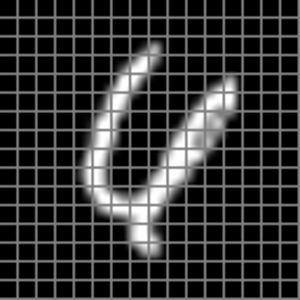
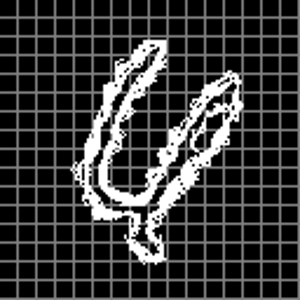
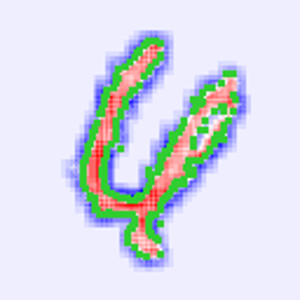
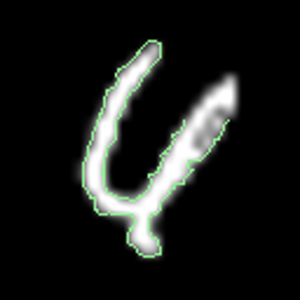

In [115]:
sensor_state_images = []
valley_sensor_insts = []

for _, si in df_sensor_instances.iterrows():
    if np.abs(si.altitude) < 3:
        valley_sensor_insts.append(si)

for sense_vector in sense_vectors:
    sensor_state_image = Image.new('L', (config.sample_size, config.sample_size), color='black')
    sensor_state_image = lay_grid(sensor_state_image, 8)
    sensor_state_image_draw = ImageDraw.Draw(sensor_state_image)

    for sensor_index, state_index in enumerate(sense_vector):
        if state_index == -1:
            continue
        
        sensor_instance = SENSOR_INSTANCES_INFO.loc[sensor_index]
        sensor_state = SENSOR_STATES_INFO.loc[[state_index]] # avoid type coercion with returning subdf [[state_index]] instead of returning Series [state_index]

        # if np.abs(altitude_map[sensor_instance.y_center, sensor_instance.x_center]) < 2:
        #     valley_sensor_insts.append(sensor_instance)

        # if sensor_state.sweep.iloc[0] == 180:
        #     continue
        
        x_center = sensor_instance.x_center
        y_center = sensor_instance.y_center
        k = sensor_instance['size'] / 2
        sweep1_vec = sensor_state.sweep1_vec.iloc[0]
        sweep2_vec = sensor_state.sweep2_vec.iloc[0]
        
        line_start = x_center, y_center
        line_end = x_center + sweep1_vec.real * k, y_center + sweep1_vec.imag * k
        sensor_state_image_draw.line([line_start, line_end], fill='white')
        
        line_start = x_center, y_center
        line_end = x_center + sweep2_vec.real * k, y_center + sweep2_vec.imag * k
        sensor_state_image_draw.line([line_start, line_end], fill='white')
    
    sensor_state_images.append(sensor_state_image)

altitude_color_map = mpl.colormaps['bwr']
altitude_images = []

for image in images:
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
    image_pil = image_pil.convert('RGB')
    # image_pil = lay_grid(image_pil, 8)
    draw = ImageDraw.Draw(image_pil)
    min_max_scaler = preprocessing.MinMaxScaler()
    altitude_map_scaled = min_max_scaler.fit_transform(altitude_map_lores.reshape(-1, 1)).reshape(altitude_map_lores.shape)
    # altitude_map_scaled = altitude_map.copy()
    # altitude_map_scaled = np.where(altitude_map_scaled < 0, altitude_map_scaled * -1, altitude_map_scaled)
    # altitude_map_scaled = min_max_scaler.fit_transform(altitude_map_scaled.reshape(-1, 1)).reshape(altitude_map.shape)

    for y in range(altitude_map_lores.shape[0]):
        for x in range(altitude_map_lores.shape[1]):
            color = altitude_color_map(altitude_map_scaled[y, x], bytes=True)
            draw.point((x, y), fill=color)

    #image_pil = ImageEnhance.Sharpness(image_pil).enhance(8)
    # image_pil = image_pil.filter(ImageFilter.CONTOUR)
    # image_pil = dilate(1, image_pil)
    # image_pil = erode(1, image_pil)

    for si in valley_sensor_insts:
        # draw.point((si.x_center, si.y_center), fill='green')    
        draw.rectangle([si.x_center_orig - 1, si.y_center_orig - 1, si.x_center_orig + 1, si.y_center_orig + 1], outline='limegreen', fill='limegreen')
    
    altitude_images.append(image_pil)
    
traj_images = []

for image in images:
    image_pil = Image.frombytes('L', size=(config.sample_size, config.sample_size), data=image.ravel())
    image_pil = image_pil.convert('RGB')
    # image_pil = lay_grid(image_pil, 8)
    draw = ImageDraw.Draw(image_pil)

    # # trajectory_to_draw = trajectory
    trajectory_to_draw = trajectory[:]

    for pt_from, pt_to in zip(trajectory_to_draw, trajectory_to_draw[1:]):
        # draw.rectangle([pt_from[0] - 2, pt_from[1] - 2, pt_from[0] + 2, pt_from[1] + 2], outline='lightgreen')
        draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='lightgreen')
        # draw.rectangle([pt_to[0] - 2, pt_to[1] - 2, pt_to[0] + 2, pt_to[1] + 2], outline='lightgreen')

    traj_images.append(image_pil)


all_images = list(map(lambda i: lay_grid(matrix_to_image(i), 8), images)) + sensor_state_images + altitude_images +  traj_images
display_images(list(map(lambda i: i.resize((300, 300)), all_images)))

In [85]:
trajectory_to_draw

[(np.int64(58), np.int64(44)),
 (np.int64(59), np.int64(42)),
 (np.int64(55), np.int64(45)),
 (np.int64(54), np.int64(46)),
 (np.int64(61), np.int64(40)),
 (np.int64(54), np.int64(48)),
 (np.int64(63), np.int64(38)),
 (np.int64(52), np.int64(50)),
 (np.int64(52), np.int64(50)),
 (np.int64(63), np.int64(37))]

In [19]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)
MINIMAL_PLUS_MINUS_DISTR_REL_DIFF = 0.9

def sense_images(images_matrix):
    images_count = images_matrix.shape[0]
    images_patches = get_image_patches_for_sensor_groups(images_matrix) # array of matrices: image no -> matrix with patches as row vectors
    assert images_patches.base is None # assert that we don't mess up original images_matrix, i.e. we get a copy
    
    mean_luminiscene_in_patches = images_patches.mean(axis=2) # matrix where each row = avg of luminisnece in each patch of an image
    mean_images_patches = mean_images_patches.reshape(-1, SENSOR_RECEPTIVE_FIELD_SQUARE).T - mean_luminiscene_in_patches.ravel()
    mean_images_patches = mean_images_patches.T.reshape(images_count, -1, SENSOR_RECEPTIVE_FIELD_SQUARE).transpose(0, 2, 1)
    # mean_images_patches is an array of matrices: image no -> matrix with mean-centered patches as column vectors

    images_patches = images_patches.transpose(0, 2, 1) # array of matrices: image no -> matrix with patches as column vectors
    assert images_patches.shape == mean_images_patches.shape
    
    abs_illum_level_pos = (SENSORS_POS @ images_patches).transpose(0, 2, 1)
    abs_illum_level_neg = (SENSORS_NEG @ images_patches).transpose(0, 2, 1)
    rel_illum_level_pos = (SENSORS_POS @ mean_images_patches).transpose(0, 2, 1) # for +/- tallying
    rel_illum_level_neg = (SENSORS_NEG @ mean_images_patches).transpose(0, 2, 1)  # for +/- tallying

    assert abs_illum_level_pos.shape == (images_count, SENSORS_COUNT, SENSOR_RECEPTIVE_FIELD_SQUARE), abs_illum_level_pos.shape
    assert abs_illum_level_neg.shape == abs_illum_level_pos.shape
    assert rel_illum_level_pos.shape == abs_illum_level_pos.shape
    assert rel_illum_level_neg.shape == abs_illum_level_pos.shape
    
    sense_vectors = []
    # For each patch in image we detect likelihood of activation of sensor in one of its (sensor's) orientation.
    # If we have some orientation (say some angle and some sweep), what is condition that given patch corresponds to this orientation?
    # Of course patch must be somewhat illuminated (regulated by SENSORS_POS) - this is to ensure that we don't get fooled by
    # when e.g. negative part is not illuminated (dot prod is 0) while positive part is illuminated very, very week (say dot prod is 5). Looks
    # like this is the reason why we don't hear very low frequencies or don't percieve low light - becase ratio get oversaturaed very quickly
    # But the key point is that sum of pixels luminiscence can meet averaged criterion only when bright pixels are concentared in area covered by SENSORS_POS
    # and dark pixels are concentrated in area covered by SENSORS_NEG. Otherwise there will disbalance.
    # To detect this condition we can look at distribution of mean-centered patches: +pixels must reside in positive part, -pixels must reside in negative part.
    # To restassure that +/- distribution of pixels actually corresponds to detectable diff in illumination we also need to compare
    # absolute illumination on positive and negative part
    for ailp_i, ailn_i, rilp_i, riln_i in zip(abs_illum_level_pos, abs_illum_level_neg, rel_illum_level_pos, rel_illum_level_neg): # Per image cycle
        # ailp_i and ailn_i both are matrices N(patches count) x M(count of sensor orientations)
        shape_save = ailp_i.shape
        ailp_i = ailp_i.ravel()
        ailn_i = ailn_i.ravel()
        ailn_i += 1e-6 # to get rid of possible division by zero errors

        # Illumination level on positive area must exceed lower threshold
        abs_illumination_scores = ailp_i.reshape(shape_save)
        abs_illumination_scores = abs_illumination_scores > MINIMAL_ILLUMINATION_ABS_LEVEL * SENSOR_AREAS 
        # abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is minimally illuminated according to given sensor's orientation
        
        # Sum of absolute illumination on positive part must exceed significiantly illumination of negative part
        # TODO: handle when no orientation is activated?
        diff_abs_illumination_scores = xp.abs(ailp_i / ailn_i)
        diff_abs_illumination_scores = diff_abs_illumination_scores >= MINIMAL_ILLUMINATION_DIFF_RATIO
        diff_abs_illumination_scores = diff_abs_illumination_scores.reshape(shape_save)
        # diff_abs_illumination_scores = matrix of N(patches count), columns - 0/1 if patch is illuminated more on positive part than on negative

        # Tally concentration of +/- pixels and compare to req-d distribution. For sensors with proper distribution ration will be around 1
        rilp_i = rilp_i.ravel()
        riln_i = riln_i.ravel()
        riln_i += 1e-6 # to get rid of possible division by zero errors
        plus_minus_distr_scores = xp.abs(rilp_i / riln_i) >= MINIMAL_PLUS_MINUS_DISTR_REL_DIFF
        plus_minus_distr_scores = plus_minus_distr_scores.reshape(shape_save)
        # plus_minus_distr_scores = matrix of N(patches count), columns - 0/1 if pixels in patch are distributed according to given sensor's orientation

        # sense_matrix = matrix of N(patches count), columns - 0/1 if all three conditions meet for given sensor orientation
        sense_matrix = (abs_illumination_scores & diff_abs_illumination_scores & plus_minus_distr_scores).astype(int) 
        sense_vector = sense_matrix.(axis=1)
        KAKTO SDELAT aggregatziyu
        sense_vectors.append(sense_vector)

    return xp.vstack(sense_vectors)

In [17]:
patches_coords = []

for _, row in SENSOR_GROUP_LAYOUT.iterrows():
    x_offset = row.x_offset
    y_offset = row.y_offset
    patch_coords = []

    for i in range(row.receptive_field_size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + row.receptive_field_size)
        patch_coords.append(stride_coords)

    patches_coords.append(patch_coords)
    
patches_coords = np.array(patches_coords)

In [18]:
patches_coords2 = []

for _, row in SENSOR_GROUP_LAYOUT.iterrows():
    x_offset = row.x_offset
    y_offset = row.y_offset

    for i in range(row.receptive_field_size):
        y = (y_offset + i) * config.sample_size
        stride_coords = np.arange(y + x_offset, y + x_offset + row.receptive_field_size)
        patches_coords2.append(stride_coords)

patches_coords2 = np.array(patches_coords2)

In [25]:
image = np.empty((config.sample_size, config.sample_size), dtype='b')
image2 = np.empty((config.sample_size, config.sample_size), dtype='b')

In [20]:
np.take(image.ravel(), patches_coords).reshape(-1, 64).shape

(1024, 64)

In [21]:
%%timeit
np.take(image.ravel(), patches_coords).reshape(-1, 64)

28.9 μs ± 20.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
np.take(image.ravel(), patches_coords).reshape(-1, 64)[0]

array([ -16,  -77,  -31,   69,   61,  115,    0,    0,  -53,    2,    0,
          0,    0,    0,    0,    0, -112,  -86,   85,  -56,   60,  115,
          0,    0,   16,   84,  -39, -125,   52,   95,    0,    0,   16,
          2,    0,    0,    0,    0,    0,    0,  -47,   90,   74,  119,
         49,   95,    0,    0,  -53,    1,    0,    0,    0,    0,    0,
          0,   77,    2,    0,    0,    0,    0,    0,    0], dtype=int8)

In [23]:
%%timeit
np.take(image.ravel(), patches_coords2).reshape(-1, 64)

29.3 μs ± 129 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
images = np.vstack([image.ravel(), image2.ravel()])

In [28]:
np.take(images, patches_coords2).reshape(-1, 64)

array([[  16,  -76,  -31, ...,    0,    0,    0],
       [  69,   61,  115, ...,    5,    7,    0],
       [   0,   16,  -76, ...,    0,    0,    0],
       ...,
       [ -32,   49,    1, ...,   95,    0,    0],
       [  52,   95,    0, ...,   54,    1, -124],
       [ -64,   50,    1, ...,   95,    0,    0]], dtype=int8)

In [24]:
np.take(image.ravel(), patches_coords2).reshape(-1, 64)[0]

array([ -16,  -77,  -31,   69,   61,  115,    0,    0,  -53,    2,    0,
          0,    0,    0,    0,    0, -112,  -86,   85,  -56,   60,  115,
          0,    0,   16,   84,  -39, -125,   52,   95,    0,    0,   16,
          2,    0,    0,    0,    0,    0,    0,  -47,   90,   74,  119,
         49,   95,    0,    0,  -53,    1,    0,    0,    0,    0,    0,
          0,   77,    2,    0,    0,    0,    0,    0,    0], dtype=int8)

In [157]:
np.take(image.ravel(), patches_coords2).reshape(-1, 64).shape

(1024, 64)

In [34]:
a = np.arange(16).reshape(4,4)
a2 = -1 + a * -1
a, a2

(array([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]),
 array([[ -1,  -2,  -3,  -4],
        [ -5,  -6,  -7,  -8],
        [ -9, -10, -11, -12],
        [-13, -14, -15, -16]]))

In [35]:
aa2 = np.vstack([a.ravel(), a2.ravel()])
aa2

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15],
       [ -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13,
        -14, -15, -16]])

In [36]:
aa2.ndim

2

In [37]:
np.take(np.vstack([a.ravel(), a2.ravel()]), [[1, 2], [5, 6]], axis=1)

array([[[ 1,  2],
        [ 5,  6]],

       [[-2, -3],
        [-6, -7]]])

In [53]:
x = np.take(np.vstack([a.ravel(), a2.ravel()]), [[1, 2], [5, 6], [9, 10], [13, 14]], axis=1).reshape(2, -1, 4)
x

array([[[  1,   2,   5,   6],
        [  9,  10,  13,  14]],

       [[ -2,  -3,  -6,  -7],
        [-10, -11, -14, -15]]])

In [55]:
x.mean(axis=2)

array([[  3.5,  11.5],
       [ -4.5, -12.5]])

In [58]:
x.reshape(-1, 4).T

array([[  1,   9,  -2, -10],
       [  2,  10,  -3, -11],
       [  5,  13,  -6, -14],
       [  6,  14,  -7, -15]])

In [60]:
y = x.reshape(-1, 4).T - x.mean(axis=2).ravel()
y

array([[-2.5, -2.5,  2.5,  2.5],
       [-1.5, -1.5,  1.5,  1.5],
       [ 1.5,  1.5, -1.5, -1.5],
       [ 2.5,  2.5, -2.5, -2.5]])

In [70]:
y.T.reshape(2, -1, 4).transpose(0, 2, 1)

array([[[-2.5, -2.5],
        [-1.5, -1.5],
        [ 1.5,  1.5],
        [ 2.5,  2.5]],

       [[ 2.5,  2.5],
        [ 1.5,  1.5],
        [-1.5, -1.5],
        [-2.5, -2.5]]])

In [54]:
x.transpose(0, 2, 1)

array([[[  1,   9],
        [  2,  10],
        [  5,  13],
        [  6,  14]],

       [[ -2, -10],
        [ -3, -11],
        [ -6, -14],
        [ -7, -15]]])

In [50]:
x.reshape(4, -1)

array([[  1,   9,   2,  10],
       [  5,  13,   6,  14],
       [ -2, -10,  -3, -11],
       [ -6, -14,  -7, -15]])

In [48]:
x.mean(axis=1).reshape(-1)

array([  3.5,  11.5,  -4.5, -12.5])

In [56]:
x - x.mean(axis=2)

ValueError: operands could not be broadcast together with shapes (2,2,4) (2,2) 

In [54]:
np.vstack([a.ravel()])

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]])

In [55]:
np.vstack([a.ravel()]).base

In [56]:
a.ravel()[np.newaxis,:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]])

In [57]:
a.ravel()[np.newaxis,:].base

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [51]:
a.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [46]:
a[:,np.newaxis]

array([[[ 0,  1,  2,  3]],

       [[ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11]],

       [[12, 13, 14, 15]]])

In [135]:
a.reshape(-1, 2)

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15]])

In [142]:
np.take(a.reshape(-1, 2), [0, 2, 5, 7], axis=0).reshape(-1, 4)

array([[ 0,  1,  4,  5],
       [10, 11, 14, 15]])

In [119]:
b = np.take(a.ravel(), [[[0,1], [4,6]], [[10, 11], [14, 15]]])
b

array([[[ 0,  1],
        [ 4,  6]],

       [[10, 11],
        [14, 15]]])

In [110]:
a.ravel()[]

(2, 2, 2)

In [120]:
b.reshape(2, -1)

array([[ 0,  1,  4,  6],
       [10, 11, 14, 15]])

In [19]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images_normal(images):
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    sense_area = (RETINA_POS @ image_masks.T).T # for check of illuminated area (number of illuminated pixels)
    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    sense_neg_level = (RETINA_NEG @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        # Per image cycle
        # sense_area_i is a matrix: row=sensor group, column=number of illuminated pixels for each receptor in this group
        sense_area_i = sense_area_i.reshape(-1, SENSOR_GROUP_SQUARE)  
        cond1 = (sense_area_i / RETINA_SENSOR_GROUP_AREAS) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)

        # sense_level_i is a matrix: row=sensor group, column=sum of illimination on positive part of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * RETINA_SENSOR_GROUP_AREAS) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)

        # sense_neg_level_i is a matrix: row=sensor group, column=sum of illimination on negative part of each receptor
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

def sense_images_onoff(images):
    sense_ress = []

    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    assert sense_level.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_level.shape

    # Check that integral illumination of sensor surface exceeds threshold (255 * area / 2)
    for sense_level_i in sense_level:
        # Per image cycle
        # sense_level_i is a matrix: row=sensor group, column=sum of illimination on surface of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        cond = (sense_level_i > 255 * RETINA_SENSOR_GROUP_AREAS / 2) # Illumination level of an area must exceed given threshold
        cond = cond.reshape(-1,)

        sense_res = cond.astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

match config.encoding_type:
    case 'normal' | 'exnormal' | 'vector': sense_images = sense_images_normal
    case 'onoff': sense_images = sense_images_onoff
    case _: assert False, config.encoding_type

# Specific samples


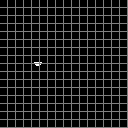
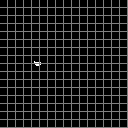
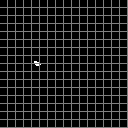
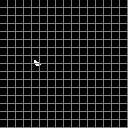
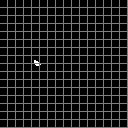
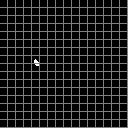
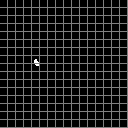
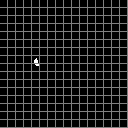
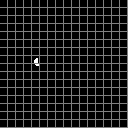
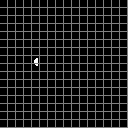
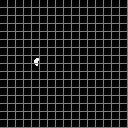
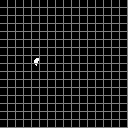
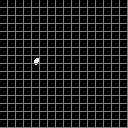
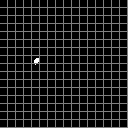
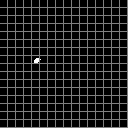
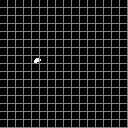
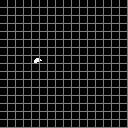
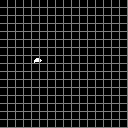
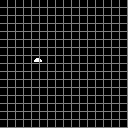
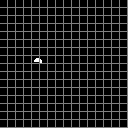
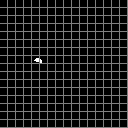
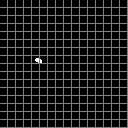
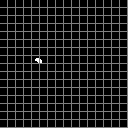
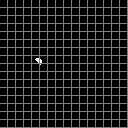
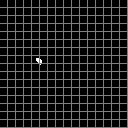

In [20]:
# For each sensor group we prepare bunch of specific samples (measured in steps here)
SPECIFIC_SAMPLES_IMG = defaultdict(list) # key - index of sensor group, value - list of specific images for this sensor group
SPECIFIC_SAMPLES_IMG_TO_NORMAL = dict() # key - index of specific image, value - normal (angle) in form of complex number
sz = config.sample_size

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    x_offset = sensor_group_info['x_offset'] # where sensor group
    y_offset = sensor_group_info['y_offset'] # is located on retina
    receptive_field_size = sensor_group_info['receptive_field_size']
    
    if config.encoding_type in ['normal', 'exnormal', 'vector']:
        steps = 360 // 10
        angle_per_step = 360 // steps
        assert steps * angle_per_step == 360, steps * angle_per_step
        
        for i in range(steps):
            canvas = Image.new('L', (sz, sz))
            draw = ImageDraw.Draw(canvas)
            # In ImageDraw angles are measured from 3 o’clock, increasing clockwise.
            angle = i * angle_per_step
            draw.chord([x_offset, y_offset, x_offset + receptive_field_size - 1, y_offset + receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
            SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)
            # remember a perpendicular to current angle with respect to a straight surface of a chord - this gonna be our normal
            angle_ccw = (360 - angle)
            normal_angle_ccw = (angle_ccw + 90) % 360
            normal_complex = np.exp((1j) * np.radians(normal_angle_ccw))
            SPECIFIC_SAMPLES_IMG_TO_NORMAL[i] = normal_complex
            assert np.isclose(np.angle(normal_complex, deg=True) % 360, normal_angle_ccw)
    elif config.encoding_type == 'onoff':
        for y in range(1, receptive_field_size + 1, 2):
            for x in range(1, receptive_field_size + 1, 2):
                for radius in range(2, receptive_field_size):
                    canvas = Image.new('L', (sz, sz))
                    draw = ImageDraw.Draw(canvas)
                    center_x = x_offset + x
                    center_y = y_offset + y
                    draw.circle([center_x, center_y], radius, fill=255)
                    draw.rectangle([-1, -1, x_offset, sz], fill=0)
                    draw.rectangle([-1, -1, sz, y_offset], fill=0)
                    draw.rectangle([x_offset + receptive_field_size, -1, sz, sz], fill=0)
                    draw.rectangle([-1, y_offset + receptive_field_size, sz, sz], fill=0)

                    if np.array(canvas).sum() > 0:
                        SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)
    else:
        assert False, config.encoding_type

sensor_group_index_to_show = RNG.choice(list(SPECIFIC_SAMPLES_IMG.keys()))
images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index_to_show][:25]
captions = list(map(lambda i: f'normal={np.round(np.angle(SPECIFIC_SAMPLES_IMG_TO_NORMAL.get(i[0], 0j), deg=True), decimals=0):.0f}', enumerate(images_to_show)))
display_images_grid(list(map(lambda x: lay_grid(x, 8), images_to_show)), captions=captions, col_count=5)

In [79]:
SPECIFIC_SAMPLES_ENCODINGS = dict()

# matrix (360, SENSOR_GROUP_SQUARE). Each row corresponds to an angle.
# Hamming dist can be used to find nearest angle
SENSOR_GROUP_NORMALS = defaultdict(lambda: np.full((360, SENSOR_GROUP_SQUARE), -1, dtype='b')) 

for sensor_group_index, specific_samples_img in tqdm(SPECIFIC_SAMPLES_IMG.items()):
    specific_samples_img = xp.array(specific_samples_img)
    specific_samples_img = specific_samples_img.reshape(specific_samples_img.shape[0], -1)
    encodings = xp_array_from_gpu(sense_images(specific_samples_img))
    SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index] = np.array(encodings)
    
    sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]

    for specific_sample_img_index, encoding in enumerate(encodings):
        normal = SPECIFIC_SAMPLES_IMG_TO_NORMAL[specific_sample_img_index]
        angle = np.round(np.angle(normal, deg=True), decimals=0)
        angle = int(angle) % 360 # here we may have angle from -180 to +180, turn to 0-360
        assert angle >= 0 and angle < 360
        sensor_vector = encoding[sensor_group_index * SENSOR_GROUP_SQUARE:(sensor_group_index + 1) * SENSOR_GROUP_SQUARE]
        sensor_group_normals[angle] = sensor_vector

    # Interpolate missing values
    # angles = np.argwhere(sensor_group_normals.sum(axis=1) > 0).ravel()
    
    # for angle in range(360):
    #     if np.any(sensor_group_normals[angle] > 0):
    #         continue
        
    #     diffs = np.abs(angles - angle)
    #     nearest_angle_index = np.argmin(diffs)
    #     nearest_angle = angles[nearest_angle_index]
    #     nearest_sensor_vector = sensor_group_normals[nearest_angle]
    #     sensor_group_normals[angle] = nearest_sensor_vector

SPECIFIC_SAMPLES_ENCODINGS[0].shape

  0%|          | 0/1024 [00:00<?, ?it/s]

(36, 16384)

# Normals

In [50]:
NORMAL_RADIUS = 4
ANGLE_TO_COMLEX = {} # key - angle (0-359), value - correspondings complex number

In [51]:
for angle in range(360):
    ANGLE_TO_COMLEX[angle] = np.exp((1j) * np.radians(angle))

In [52]:
def angle_to_complex(angle):
    angle = int(angle) % 360
    return ANGLE_TO_COMLEX[angle]

In [53]:
ENDPOINT_TO_RAYS_INDEX = defaultdict(set)
RAYS = []
rays_set = set()
path = np.vstack([np.arange(0, NORMAL_RADIUS + 1), np.zeros((2, NORMAL_RADIUS + 1))]).T # list of points from center to periphery

for i in range(360):
    theta = math.radians(i)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    # Clockwise rotation
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotated_path = np.round(transf @ path.T, decimals=0).astype(int)
    ray = tuple(zip(rotated_path[0], rotated_path[1]))

    if not ray in rays_set:
        rays_set.add(ray)
        RAYS.append(ray)

for ray_index, ray in enumerate(RAYS):
    for point in ray:
        if point != (0, 0):
            ENDPOINT_TO_RAYS_INDEX[(point)].add(ray)

ENDPOINT_TO_RAYS_INDEX.default_factory = None # seal index, prevent accidential insertions

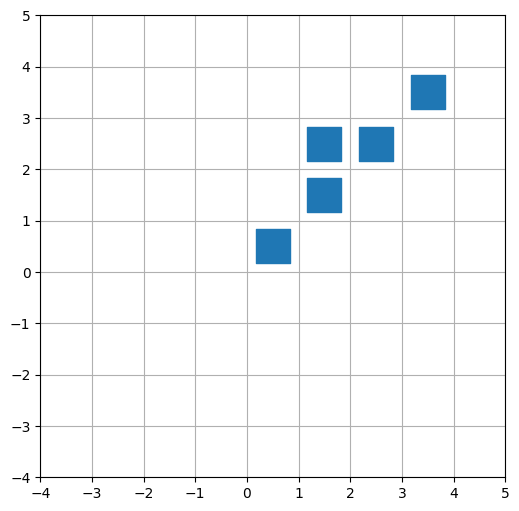

In [54]:
ray_index = 10
ray = np.array(RAYS[ray_index])

plt.figure(figsize=(6,6))
plt.scatter(ray[:,0] + 0.5, -ray[:,1] + 0.5, s=600, marker='s')
plt.ylim(-NORMAL_RADIUS, NORMAL_RADIUS + 1)
plt.xlim(-NORMAL_RADIUS, NORMAL_RADIUS + 1)
plt.grid()
plt.show()

# Image offsets

In [27]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        # Clockwise rotation
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

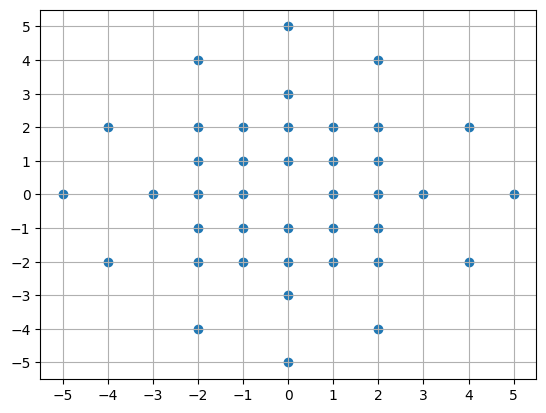

(40, 2)

In [28]:
points1 = get_grid_offsets(-2, 2)
points2 = get_clock_offsets([5, 3])
points = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(points1, points2)))))
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(points) * -1, np.max(points) + 1, 1))
plt.yticks(range(np.max(points) * -1, np.max(points) + 1, 1))
plt.show()
points.shape

In [29]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)

        # offset by x
        x = off[0]
        image_offed = np.roll(image_offed, x, axis=1)
        cols_to_wipeout = [min(x, 0) + i for i in range(abs(x))]
        image_offed[:,cols_to_wipeout] = 0

        # offset by y
        y = off[1]
        image_offed = np.roll(image_offed, y, axis=0)
        rows_to_wipeout = [min(y, 0) + i for i in range(abs(y))]
        image_offed[rows_to_wipeout,:] = 0
        
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)


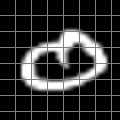
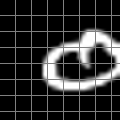
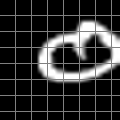
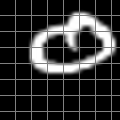
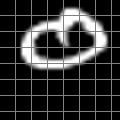
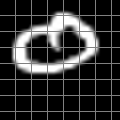
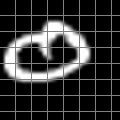
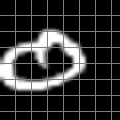
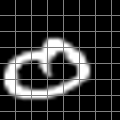
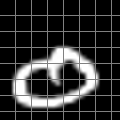
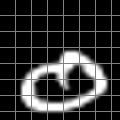
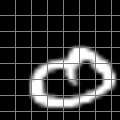
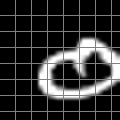
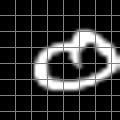
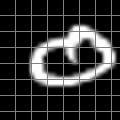
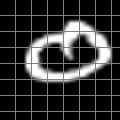
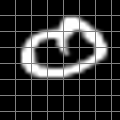
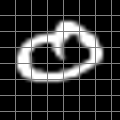
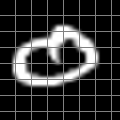
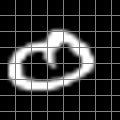
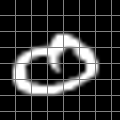
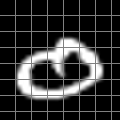
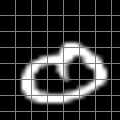
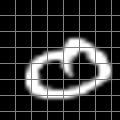
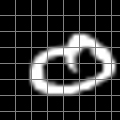
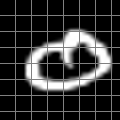
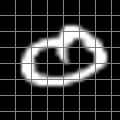
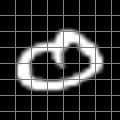
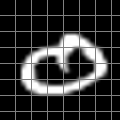

In [30]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

captions = list(map(lambda x: f'x={x[0]}, y={x[1]}', xy_offsets))
display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), captions=captions, col_count=8)

# Table 'stride_hdvs'

In [31]:
%%time
# STRIDE_HDV_TYPE = 'random' # each stride hdv is a random hdv
STRIDE_HDV_TYPE = 'smooth' # each stride hdv is a collection of comprising sensor hdv - cos sim between similar strides

STRIDE_HDVS = dict() # to be used in RO mode ONLY in multiprocessing without locks

if not is_table_exists(hdv_db_con, 'stride_hdvs'):
    # Generate all possible stride hdvs in advance.
    # This would allow to use stride_hdvs in RO-mode in multiprocessing without any locks and data corruption
    # Generate stride HDV from a common pool of sensor HDV. This is to make stride hdvs which share the same sensors to be close in cos sim space
    if SENSOR_GROUP_SQUARE > 16:
        assert False, f'Not implemented yet for SENSOR_GROUP_SQUARE={SENSOR_GROUP_SQUARE}'

    sensor_hdvs = hdc(SENSOR_GROUP_SQUARE)

    for i in tqdm(range(1, pow(2, SENSOR_GROUP_SQUARE))):
        stride_code = np.binary_repr(i, width=SENSOR_GROUP_SQUARE) # e.g. 1100100010001110
        assert stride_code != '0' * SENSOR_GROUP_SQUARE

        match STRIDE_HDV_TYPE:
            case 'smooth':
                sensor_hdv_indices = list(map(int, list(stride_code))) # e.g [1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0]
                stride_hdv = np.compress(sensor_hdv_indices, sensor_hdvs, axis=0)
                STRIDE_HDVS[stride_code] = hdc.bundle(stride_hdv) # similar stride hdv for sensor groups sharing same receptors (more shared receptors -> more similarity)
            case 'random':
                STRIDE_HDVS[stride_code] = hdc() # distinct stride hdv for each variant of sensor group
            case _:
                assert False, STRIDE_HDV_TYPE

    cur = hdv_db_con.cursor()
    cur.execute('CREATE TABLE stride_hdvs(code TEXT, hdv TEXT)')
    cur.execute('CREATE UNIQUE INDEX ix_stride_hdvs_code ON stride_hdvs(code)')
    cur.executemany('INSERT INTO stride_hdvs (code, hdv) VALUES (:code, :hdv)', [{'code': code, 'hdv': hdv} for code, hdv in STRIDE_HDVS.items()])
    hdv_db_con.commit()
else:
    df_stride_hdvs = pd.read_sql('SELECT code, hdv FROM stride_hdvs', con=hdv_db_con)
    hdvs = map(lambda x: np.frombuffer(x, dtype='b'), df_stride_hdvs['hdv'])
    STRIDE_HDVS.update(zip(df_stride_hdvs['code'], hdvs))

CPU times: user 292 ms, sys: 627 ms, total: 919 ms
Wall time: 970 ms


In [32]:
if STRIDE_HDV_TYPE == 'smooth':
    random_stride_code = RNG.choice(list(STRIDE_HDVS.keys()))
    random_stride_hdv = STRIDE_HDVS[random_stride_code]
    sims = np.array(list(map(lambda item: hdc.sim(random_stride_hdv, item[1]) if item[0] != random_stride_code else 0, STRIDE_HDVS.items())))
    # there must be bunch of similar stride hdvs in DB
    assert (sims > Hdc.COS_SIM_THRESHOLD).sum() > 0

    pivot_angle = RNG.integers(10, 350)
    pivot_sensor_vector =  SENSOR_GROUP_NORMALS[0][pivot_angle]
    pivot_stride_code = ''.join(map(str, pivot_sensor_vector.tolist()))
    pivot_stride_hdv = STRIDE_HDVS[pivot_stride_code]
    
    for angle in range(pivot_angle - 10, pivot_angle + 10):
        sensor_vector =  SENSOR_GROUP_NORMALS[0][angle]
        stride_code = ''.join(map(str, sensor_vector.tolist()))
        stride_hdv = STRIDE_HDVS[stride_code]
        sim = hdc.sim(stride_hdv, pivot_stride_hdv)
        assert sim > Hdc.COS_SIM_THRESHOLD
        print(f'Pivot angle={pivot_angle}, angle={angle}, sim={sim:.2f}')       

Pivot angle=18, angle=8, sim=0.68
Pivot angle=18, angle=9, sim=0.68
Pivot angle=18, angle=10, sim=0.68
Pivot angle=18, angle=11, sim=0.68
Pivot angle=18, angle=12, sim=0.68
Pivot angle=18, angle=13, sim=0.68
Pivot angle=18, angle=14, sim=0.68
Pivot angle=18, angle=15, sim=0.68
Pivot angle=18, angle=16, sim=1.00
Pivot angle=18, angle=17, sim=1.00
Pivot angle=18, angle=18, sim=1.00
Pivot angle=18, angle=19, sim=1.00
Pivot angle=18, angle=20, sim=1.00
Pivot angle=18, angle=21, sim=1.00
Pivot angle=18, angle=22, sim=1.00
Pivot angle=18, angle=23, sim=1.00
Pivot angle=18, angle=24, sim=1.00
Pivot angle=18, angle=25, sim=1.00
Pivot angle=18, angle=26, sim=0.83
Pivot angle=18, angle=27, sim=0.83


In [33]:
# encoding aka sensor vector
def encoding_to_hdv(encoding):
    encoding_stride_hdvs = []
    empty_stride = '0' * SENSOR_GROUP_SQUARE
    # Fast conversion to string of 0s & 1s
    encoding_digits = ['0', '1']
    encoding_str = ''.join(np.take(encoding_digits, encoding).tolist())

    for stride_index in range(0, len(encoding_str), SENSOR_GROUP_SQUARE):
        stride_code = encoding_str[stride_index:stride_index + SENSOR_GROUP_SQUARE]

        if stride_code == empty_stride:
            continue
        
        stride_hdv = STRIDE_HDVS[stride_code] # all stride_codes must be pregenerated beforehand!!!
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        encoding_stride_hdvs.append(stride_hdv)

    if encoding_stride_hdvs:
        encoding_hdv = hdc.bundle(encoding_stride_hdvs)
        assert encoding_hdv.shape[0] == hdc.N, encoding_hdv.shape
    else:
        encoding_hdv = hdc() # use fresh whitenoise hdv to denote blank image. Its cos sim will be near 0 when doing meaningful comparison with anything in the future

    return encoding_hdv

# Test of normals

In [34]:
SQUARE_OF_TWO = np.sqrt(2)

In [37]:
def encoding_to_normal_map(encoding):
    assert encoding.shape == (SENSORS_COUNT,)
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    normal_map = np.zeros(SENSOR_GROUPS_COUNT, 'F').reshape(SENSOR_GROUPS_ROOT, -1)
    assert normal_map.shape[0] == normal_map.shape[1]
    normal_influencers = defaultdict(set) # key - (i,j) of point in normal map, value - set of (i,j) denoting influencers of this point

    # Deploy primary normals (seeding)
    seed_normals = []
    
    for sensor_group_index, sensor_vector in enumerate(encoding):
        assert sensor_vector.shape == (SENSOR_GROUP_SQUARE, )
        
        if np.all(sensor_vector == 0):
            continue
            
        sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]
        hamming_dist = np.count_nonzero(sensor_vector != sensor_group_normals, axis=1)
        best_angle = np.argmin(hamming_dist)
        assert best_angle >= 0 and best_angle < 360
        i = sensor_group_index // normal_map.shape[0]
        j = sensor_group_index % normal_map.shape[0]
        normal_map[i, j] = angle_to_complex(best_angle)
        seed_normals.append((i, j))

    # Discover points which seed normals influence via simple ray tracing
    for i, j in seed_normals:
        for ray in RAYS:
            for point_dx, point_dy in ray:
                if point_dx == 0 and point_dy == 0:
                    continue
                    
                pi = point_dy + i
                pj = point_dx + j

                if pi < 0 or pi >= normal_map.shape[0] or pj < 0 or pj >= normal_map.shape[0]:
                    break # break out of universe boundaries, stop with this ray
                elif normal_map[pi, pj] != 0:
                    break # got hit some other normal! stop this ray tracing
                
                normal_influencers[(pi, pj)].add((i, j))

    for i_j, influencers in normal_influencers.items():
        contribs = []
        min_d = math.inf
    
        for i2, j2 in influencers:
            influencer_normal = normal_map[i2, j2]
            vec = i_j[1] - j2, (-i_j[0]) - (-i2)  # vector pointing from influencer to normal we are computing right now
            d = np.linalg.norm(vec) # distance from i_j to influencer
            min_d = min(d, min_d)
            vec /= d
            colliniarity_scale = vec[0] *  influencer_normal.real + vec[1] * influencer_normal.imag # aka cos sim
            denom = max(d, SQUARE_OF_TWO) ** 2 # for d=1 we get denom=2, for d > 1 we get denom = d**2
            scale = max(0, colliniarity_scale) / denom
            contribs.append(influencer_normal * scale)

        # Prune too large normals which could happen due to rough granularity
        normal = np.sum(contribs)
        normal_abs = np.absolute(normal)
        max_normal_abs = 1 * (1 / (max(min_d, SQUARE_OF_TWO)) ** 2)
        
        if normal_abs > max_normal_abs:
            normal *= max_normal_abs / normal_abs # scale down to max_normal_abs
        elif normal_abs < 1 / NORMAL_RADIUS ** 2:
            normal = 0 # get rid of too weak normals
        
        normal_map[i_j] = normal
    
    return normal_map

def normal_map_to_encoding(normal_map):
    encoding = np.zeros(SENSORS_COUNT, dtype='b')
    normal_map = normal_map.ravel()
    angles = np.round(np.angle(normal_map, deg=True), decimals=0).astype(int)
    angles = angles % 360
    
    for i in range(normal_map.shape[0]):
        normal = normal_map[i]
    
        if normal == 0:
            continue
    
        angle = angles[i]
        sensor_vector = SENSOR_GROUP_NORMALS[i][angle]
        encoding[i * SENSOR_GROUP_SQUARE:(i + 1) * SENSOR_GROUP_SQUARE] = sensor_vector

    return encoding

def encoding_to_joint_map(encoding):
    assert encoding.shape == (SENSORS_COUNT,)
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    normal_map = np.zeros(SENSOR_GROUPS_COUNT, 'F').reshape(SENSOR_GROUPS_ROOT, -1)
    assert normal_map.shape[0] == normal_map.shape[1]

    # Deploy primary normals (seeding)
    seed_normals = []
    
    for sensor_group_index, sensor_vector in enumerate(encoding):
        assert sensor_vector.shape == (SENSOR_GROUP_SQUARE, )
        
        if np.all(sensor_vector == 0):
            continue
            
        sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]
        hamming_dist = np.count_nonzero(sensor_vector != sensor_group_normals, axis=1)
        best_angle = np.argmin(hamming_dist)
        assert best_angle >= 0 and best_angle < 360
        i = sensor_group_index // normal_map.shape[0]
        j = sensor_group_index % normal_map.shape[0]
        normal_map[i, j] = angle_to_complex(best_angle)
        seed_normals.append((i, j))

    return normal_map


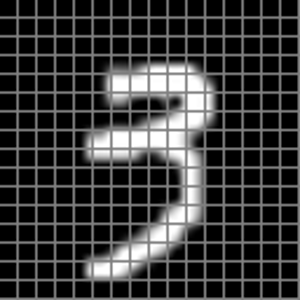
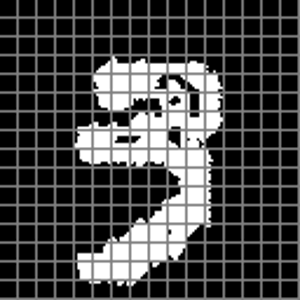
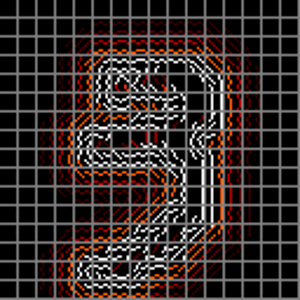
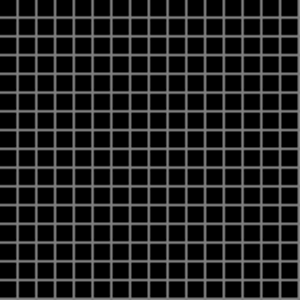

In [86]:
images = []
captions = []

image_index = RNG.choice(len(x_train))
# image_index = 11198 # 5
# image_index = 3 # 1
random_img_data = x_train[image_index]
random_img = Image.frombytes('L', size=(28, 28), data=random_img_data)
random_img = random_img.resize((config.sample_size, config.sample_size))
images.append(random_img)
captions.append(f'#{image_index}')

random_img_arr = xp.array([random_img])
random_img_arr = random_img_arr.reshape(1, -1)
random_img_encoding = xp_array_from_gpu(sense_images(random_img_arr))
random_img_encoding = random_img_encoding.reshape(SENSOR_GROUPS_COUNT, -1)
assert (random_img_encoding == 1).sum() > 0

sz = config.sample_size
layers = []

for sensor_group_index, sensor_group in enumerate(random_img_encoding):
    assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
    
    if np.all(sensor_group == 0):
        continue
        
    # Find most similar reaction among specific samples of reactions for given sensor group by hamming dist
    speficic_samples_encodings_for_sensor_group = SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index]
    a = sensor_group
    b = speficic_samples_encodings_for_sensor_group[:,sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE]
    hamming_dist = np.count_nonzero(a != b, axis=1)
    best_i = np.argmin(hamming_dist)
    most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
    assert most_similar_specific_sample.shape == (sz, sz)
    layers.append(most_similar_specific_sample)

# SENSOR MAP IMAGE
sensor_map_image = np.zeros((sz, sz))

for layer in layers:
    sensor_map_image += layer

sensor_map_image[sensor_map_image != 0] = 255
images.append(matrix_to_image(sensor_map_image))
captions.append('')

# NORMAL MAP IMAGE
normal_map = encoding_to_normal_map(random_img_encoding.ravel())
normal_color_map = mpl.colormaps['hot']
normal_map_image = Image.new('RGBA', (sz, sz), color='black')
normal_map_image_draw = ImageDraw.Draw(normal_map_image)
k = sz / normal_map.shape[0]
k_half = k / 2

for i in range(normal_map.shape[0]):
    for j in range(normal_map.shape[1]):
        normal = normal_map[i, j]

        if normal == 0:
            continue
        
        tangent = -normal.imag, normal.real # manual rotate 90
        tangent /= np.linalg.norm(tangent)
        center_x = (j + 0.5) * k
        center_y = (i + 0.5) * k
        line_start = center_x + tangent[0] * k_half, center_y - tangent[1] * k_half
        line_end = center_x - tangent[0] * k_half, center_y + tangent[1] * k_half
        normal_color = normal_color_map(np.absolute(normal), bytes=True)
        # normal_color = normal_color_map(1.0, bytes=True)
        normal_map_image_draw.line([line_start, line_end], fill=normal_color)

images.append(normal_map_image)
captions.append('')

# JOINT MAP
# joint_map = encoding_to_joint_map(random_img_encoding.ravel())
# joint_color_map = mpl.colormaps['hot']
joint_map_image = Image.new('RGBA', (sz, sz), color='black')
joint_map_image_draw = ImageDraw.Draw(joint_map_image)
# k = sz / joint_map.shape[0]
# k_half = k / 2


# for i in range(joint_map.shape[0]):
#     for j in range(joint_map.shape[1]):
#         pass

images.append(joint_map_image)
captions.append('')

display_images(list(map(lambda i: lay_grid(i, 8).resize((300, 300)), images)), captions=captions)

In [149]:
[k for k in globals().keys() if 'SENSOR_GROUP' in k]

['SENSOR_GROUPS_COUNT',
 'SENSOR_GROUPS_ROOT',
 'SENSOR_GROUP_SIZE',
 'SENSOR_GROUP_SQUARE',
 'SENSOR_GROUPS_IMG',
 'SENSOR_GROUPS',
 'SENSOR_GROUP_AREAS',
 'SENSOR_GROUP_DISTRIBUTOR',
 'RETINA_SENSOR_GROUP_INFOS',
 'RETINA_SENSOR_GROUP_AREAS',
 'SENSOR_GROUP_NORMALS']

In [150]:
RETINA_SENSOR_GROUP_INFOS

,group_index,field_size_index,x_offset,y_offset,receptive_field_size,x_center,y_center,radius
0,0,0,0,0,8,4,4,4
1,1,0,3,0,8,7,4,4
2,2,0,7,0,8,11,4,4
3,3,0,11,0,8,15,4,4
4,4,0,15,0,8,19,4,4
...,...,...,...,...,...,...,...,...
1019,1019,0,104,120,8,108,124,4
1020,1020,0,108,120,8,112,124,4
1021,1021,0,112,120,8,116,124,4
1022,1022,0,116,120,8,120,124,4


In [177]:
def get_angle_diff(an1, an2):
    andiff = an2 - an1
    andiff = int(-np.sign(andiff) * 360 + andiff if abs(andiff) > 180 else andiff)
    return andiff


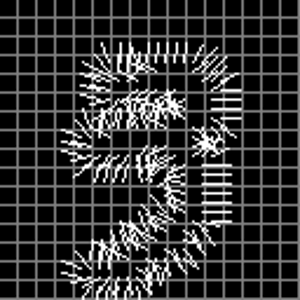
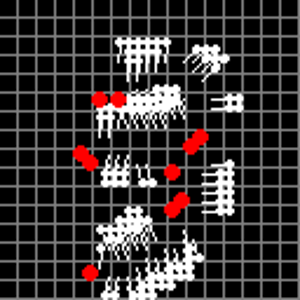

In [192]:
encoding = random_img_encoding.ravel()

assert encoding.shape == (SENSORS_COUNT,)
encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
normal_map = np.zeros(SENSOR_GROUPS_COUNT, 'F').reshape(SENSOR_GROUPS_ROOT, -1)
filtered_normal_map = np.zeros(SENSOR_GROUPS_COUNT, 'F').reshape(SENSOR_GROUPS_ROOT, -1)
angle_map = np.full(SENSOR_GROUPS_COUNT, -1, 'i').reshape(SENSOR_GROUPS_ROOT, -1)
homo_angle_map = np.full(SENSOR_GROUPS_COUNT, -1, 'i').reshape(SENSOR_GROUPS_ROOT, -1)
assert normal_map.shape[0] == normal_map.shape[1]

# Deploy primary normals (seeding)
seed_normals = []
seed_normal_to_xy = {}
hetero_ijs = set()

for sensor_group_index, sensor_vector in enumerate(encoding):
    assert sensor_vector.shape == (SENSOR_GROUP_SQUARE, )
    
    if np.all(sensor_vector == 0):
        continue
        
    sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]
    hamming_dist = np.count_nonzero(sensor_vector != sensor_group_normals, axis=1)
    best_angle = np.argmin(hamming_dist)
    assert best_angle >= 0 and best_angle < 360
    i = sensor_group_index // normal_map.shape[0]
    j = sensor_group_index % normal_map.shape[0]
    normal_map[i, j] = angle_to_complex(best_angle)
    seed_normals.append((i, j))
    r = RETINA_SENSOR_GROUP_INFOS.loc[sensor_group_index]
    seed_normal_to_xy[(i, j)] = (r.x_center, r.y_center, r.radius)
    assert best_angle % 10 == 0, (sensor_group_index, sensor_vector)
    angle_map[i, j] = best_angle
    hetero_ijs.add((i, j))

# for seed_normal_ij in seed_normals:
#     seed_normal = normal_map[seed_normal_ij]
#     normal_group = [seed_normal]
    
#     # Get neighbours
#     for seed_normal_ij2 in seed_normals:
#         if seed_normal_ij2 == seed_normal_ij:
#             continue

#         seed_normal_xy = seed_normal_to_xy[seed_normal_ij]
#         seed_normal2_xy = seed_normal_to_xy[seed_normal_ij2]
#         vec = seed_normal_xy[0] - seed_normal2_xy[0], seed_normal_xy[1] - seed_normal2_xy[1]
#         # vec = seed_normal_ij[0] - seed_normal_ij2[0], seed_normal_ij[1] - seed_normal_ij2[1]
#         d = np.linalg.norm(vec)

#         # if d < 2:
#         if d < seed_normal_xy[2] * 2:
#             seed_normal2 = normal_map[seed_normal_ij2]
#             dot_prod = seed_normal.real * seed_normal2.real + seed_normal.imag * seed_normal2.imag
    
#             if dot_prod <= 0:
#                 continue

#             normal_group.append(normal_map[seed_normal_ij2])

#     filtered_normal_map[seed_normal_ij] = np.sum(normal_group) / len(normal_group)

hetero_angle_map = angle_map.copy()

# for ij in hetero_ijs:
#     assert hetero_angle_map[ij] != -1

# HOMO
class HomoGroup(object):
    def __init__(self):
        self.ijs = set()
        self.angle = -1 # 0-360
        
homogroups = [] # HomoGroups
ij_to_homogroup = dict()

for _ in range(10):
    unhandled_ij = seed_normals.copy()
    RNG.shuffle(unhandled_ij)
    
    for seed_normal_ij in unhandled_ij:
        seed_normal = normal_map[seed_normal_ij]
        neighbours = []
        angles = []
        
        # Get neighbours
        for seed_normal_ij2 in seed_normals:
            if seed_normal_ij2 == seed_normal_ij:
                continue
    
            # seed_normal_xy = seed_normal_to_xy[seed_normal_ij]
            # seed_normal2_xy = seed_normal_to_xy[seed_normal_ij2]
            # vec = seed_normal_xy[0] - seed_normal2_xy[0], seed_normal_xy[1] - seed_normal2_xy[1]
            vec = seed_normal_ij[0] - seed_normal_ij2[0], seed_normal_ij[1] - seed_normal_ij2[1]
            d = np.linalg.norm(vec)
    
            if d < 2:
            # if d < seed_normal_xy[2] * 2:
                seed_normal2 = normal_map[seed_normal_ij2]
                dot_prod = seed_normal.real * seed_normal2.real + seed_normal.imag * seed_normal2.imag
        
                if dot_prod <= 0:
                    continue
    
                neighbours.append(seed_normal_ij2)
                angles.append(angle_map[seed_normal_ij2])

        # Join to majority of neighbours
        if len(angles) > 2:
            c = Counter(angles)
            majority_angle = c.most_common(1)[0]

            if majority_angle[1] > len(angles) / 2:
                angle_map[seed_normal_ij] = majority_angle[0]
                filtered_normal_map[seed_normal_ij] = angle_to_complex(majority_angle[0])
                homo_angle_map[seed_normal_ij] = majority_angle[0]

                hetero_angle_map[seed_normal_ij] = -1
                hetero_ijs.discard(seed_normal_ij)

                for neighbour_ij in neighbours:
                    hetero_angle_map[neighbour_ij] = -1
                    hetero_ijs.discard(neighbour_ij)

for h in homo_angle_map:
    LOG(' '.join(map(lambda he: f'{str(he) if he >-1 else '':3}', h)))


# for h in hetero_angle_map:
#     LOG(' '.join(map(lambda he: f'{he:3}', h)))

# for i in range(hetero_angle_map.shape[0]):
#     for j in range(hetero_angle_map.shape[1]):
#         if hetero_angle_map[i, j] != -1:
#             assert (i, j) in hetero_ijs
#         else:
#             assert not (i, j) in hetero_ijs

# HETERO
tolerance_angle_diff = 45
pivot_points = []
hetero_ijs_list = list(hetero_ijs)
RNG.shuffle(hetero_ijs_list)

for hetero_ij in hetero_ijs_list:
    hetero_angle = hetero_angle_map[hetero_ij]

    if hetero_angle < 0:
        continue

    # Aggregate all normals which are in direct viscinity and have angle +- tolerance_angle_diff
    hetero_angle_map[hetero_ij] = -1
    work_ijs = deque([hetero_ij])
    pivot_points.append(hetero_ij)

    while work_ijs:
        work_ij = work_ijs.popleft()

        for work_ij2 in hetero_ijs_list:
            hetero_angle2 = hetero_angle_map[work_ij2]

            if hetero_angle2 < 0:
                continue
    
            vec = work_ij[0] - work_ij2[0], work_ij[1] - work_ij2[1]
            d = np.linalg.norm(vec)
    
            if d < 2:
                # direct viscinity
                angle_diff = get_angle_diff(hetero_angle2, hetero_angle)

                if abs(angle_diff) <= tolerance_angle_diff:
                    hetero_angle_map[work_ij2] = -1
                    work_ijs.append(work_ij2)



# joint_color_map = mpl.colormaps['hot']

k = sz / filtered_normal_map.shape[0]
k_half = k / 2
normal_arrow_len = SENSOR_RECEPTIVE_FIELD_SIZES[0]

normal_map_image = Image.new('RGBA', (sz, sz), color='black')
normal_map_image_draw = ImageDraw.Draw(lay_grid(normal_map_image, 8))


for i in range(normal_map.shape[0]):
    for j in range(normal_map.shape[1]):
        normal = normal_map[i, j]

        if normal == 0:
            continue

        assert np.isclose(np.absolute(normal), 1)
        center_x = (j + 0.5) * k
        center_y = (i + 0.5) * k
        line_start = center_x, center_y
        line_end = center_x + normal.real * normal_arrow_len, center_y - normal.imag * normal_arrow_len
        normal_color = normal_color_map(np.absolute(normal), bytes=True)
        normal_map_image_draw.line([line_start, line_end], fill=normal_color)

filtered_normal_map_image = Image.new('RGBA', (sz, sz), color='black')
filtered_normal_map_image_draw = ImageDraw.Draw(lay_grid(filtered_normal_map_image, 8))

for i in range(filtered_normal_map.shape[0]):
    for j in range(filtered_normal_map.shape[1]):
        normal = filtered_normal_map[i, j]

        # if normal == 0 or np.absolute(normal) > 0.98:
        if normal == 0:
            continue

        qqq = seed_normal_to_xy[(i, j)]

        if qqq[0] >= 80 and qqq[1] >= 80 and qqq[0] < 100 and qqq[1] < 100:
            LOG(f'{i:2},{j:2} {qqq}   {np.angle(normal, deg=True)} {np.absolute(normal):.2f}    {np.angle(normal_map[i, j], deg=True)} {np.absolute(normal_map[i, j]):.2f}')

        center_x = (j + 0.5) * k
        center_y = (i + 0.5) * k
        line_start = center_x, center_y
        line_end = center_x + normal.real * normal_arrow_len, center_y - normal.imag * normal_arrow_len
        normal_color = normal_color_map(np.absolute(normal), bytes=True)
        filtered_normal_map_image_draw.line([line_start, line_end], fill=normal_color)
        filtered_normal_map_image_draw.circle(line_end, radius=1.5, fill=normal_color)

        # tangent = -normal.imag, normal.real # manual rotate 90
        # tangent /= np.linalg.norm(tangent)
        # center_x = (j + 0.5) * k
        # center_y = (i + 0.5) * k
        # line_start = center_x + tangent[0] * normal_arrow_len, center_y - tangent[1] * normal_arrow_len
        # line_end = center_x - tangent[0] * normal_arrow_len, center_y + tangent[1] * normal_arrow_len
        # normal_color = normal_color_map(np.absolute(normal), bytes=True)
        # filtered_normal_map_image_draw.line([line_start, line_end], fill=normal_color)

for pivot_point in pivot_points:
    xy = seed_normal_to_xy[pivot_point]
    filtered_normal_map_image_draw.circle(xy, radius=3, fill='red')
        

display_images(list(map(lambda i: i.resize((300, 300)), [normal_map_image, filtered_normal_map_image])))

In [184]:
pivot_points

[(15, 15),
 (13, 20),
 (9, 11),
 (16, 8),
 (11, 12),
 (16, 20),
 (30, 9),
 (21, 19),
 (28, 8),
 (17, 9),
 (21, 18)]

In [162]:
an1 = 0 % 360
an2 = 340 % 360
max_an = max(an1, an2)
min_an = min(an1, an2)
diff1 = max_an - min_an
diff2 = min_an - max_an
diff = diff1 if abs(diff1) < abs(diff2) else diff2
an1, an2, diff

(0, 340, -340)

In [175]:
an1 = 0 % 360
an2 = 10 % 360
andiff = an2 - an1
andiff = int(-np.sign(andiff) * 360 + andiff if abs(andiff) > 180 else andiff)
an1, an2, an2 - an1, andiff

(0, 10, 10, 10)

In [155]:
(-1) ** (an2 // 180)

-1

In [176]:
an1 = 0
an2 = 190
andiff = ((an2 - an1) % 360 - 360)
andiff

df_x = pd.DataFrame(columns=list(range(0, 360, 10)))

for an1 in range(0, 360, 10):
    andiffs = []
    
    for an2 in range(0, 360, 10):
        andiff = an2 - an1
        andiff = int(-np.sign(andiff) * 360 + andiff if abs(andiff) > 180 else andiff)
        andiffs.append(andiff)
        
    df_x.loc[an1] = andiffs
    
df_x

,0,10,20,30,40,50,60,70,80,90,...,260,270,280,290,300,310,320,330,340,350
0,0,10,20,30,40,50,60,70,80,90,...,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10
10,-10,0,10,20,30,40,50,60,70,80,...,-110,-100,-90,-80,-70,-60,-50,-40,-30,-20
20,-20,-10,0,10,20,30,40,50,60,70,...,-120,-110,-100,-90,-80,-70,-60,-50,-40,-30
30,-30,-20,-10,0,10,20,30,40,50,60,...,-130,-120,-110,-100,-90,-80,-70,-60,-50,-40
40,-40,-30,-20,-10,0,10,20,30,40,50,...,-140,-130,-120,-110,-100,-90,-80,-70,-60,-50
50,-50,-40,-30,-20,-10,0,10,20,30,40,...,-150,-140,-130,-120,-110,-100,-90,-80,-70,-60
60,-60,-50,-40,-30,-20,-10,0,10,20,30,...,-160,-150,-140,-130,-120,-110,-100,-90,-80,-70
70,-70,-60,-50,-40,-30,-20,-10,0,10,20,...,-170,-160,-150,-140,-130,-120,-110,-100,-90,-80
80,-80,-70,-60,-50,-40,-30,-20,-10,0,10,...,180,-170,-160,-150,-140,-130,-120,-110,-100,-90
90,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,...,170,180,-170,-160,-150,-140,-130,-120,-110,-100


In [83]:
for r in angle_map:
    LOG(r)

In [ ]:
# sensor_group_normals = SENSOR_GROUP_NORMALS[sensor_group_index]
# hamming_dist = np.count_nonzero(sensor_vector != sensor_group_normals, axis=1)
# best_angle = np.argmin(hamming_dist)
# assert best_angle >= 0 and best_angle < 360

In [110]:
hetero_angle_map[i].shape

(32,)

In [120]:
i, j

(28, 10)

In [128]:
hetero_ijs

{(7, 10),
 (8, 10),
 (8, 11),
 (9, 10),
 (9, 11),
 (10, 10),
 (10, 11),
 (10, 12),
 (11, 11),
 (11, 12),
 (13, 20),
 (13, 21),
 (13, 22),
 (13, 23),
 (14, 8),
 (14, 20),
 (14, 21),
 (14, 22),
 (15, 8),
 (15, 9),
 (15, 15),
 (15, 16),
 (15, 17),
 (15, 20),
 (15, 21),
 (16, 8),
 (16, 9),
 (16, 17),
 (16, 18),
 (16, 20),
 (17, 9),
 (17, 17),
 (17, 18),
 (17, 19),
 (18, 18),
 (18, 19),
 (19, 19),
 (20, 19),
 (21, 18),
 (21, 19),
 (22, 17),
 (22, 18),
 (22, 19),
 (23, 17),
 (23, 18),
 (28, 8),
 (29, 8),
 (29, 9),
 (30, 9)}

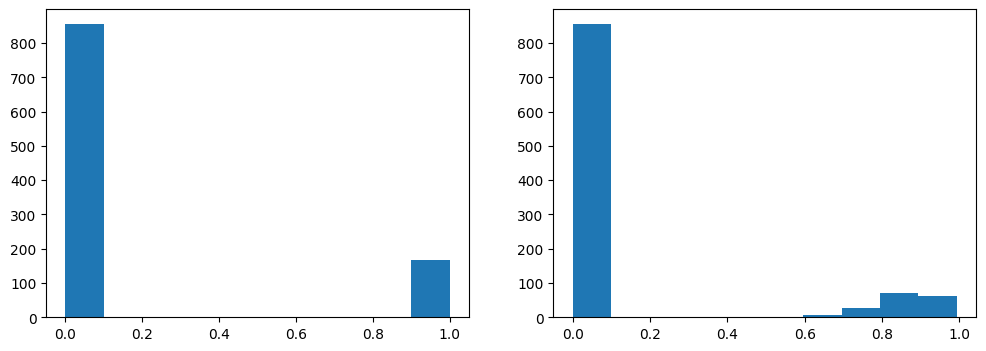

In [183]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.hist(np.absolute(normal_map).ravel())

plt.subplot(1,2,2)
plt.hist(np.absolute(filtered_normal_map).ravel())
plt.show()

In [37]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[image_index]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    img = img.resize((config.sample_size, config.sample_size))
    image_offsets = xp_array_to_gpu(generate_image_offsets(np.array(img).ravel(), xy_offsets))

image_offset_encodings = xp_array_from_gpu(sense_images(image_offsets))
assert image_offset_encodings.shape == (image_offsets.shape[0], SENSORS_COUNT)

In [38]:
hdvs_old = []

for image_offset_encoding in tqdm(image_offset_encodings):
    hdvs_old.append(encoding_to_hdv(image_offset_encoding))

hdvs_old = np.array(hdvs_old)
hdvs_old = hdc.normalize(hdvs_old)
cross_sim = hdvs_old @ hdvs_old.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

count    406.000000
mean       0.370982
std        0.142148
min        0.054230
25%        0.265944
50%        0.365359
75%        0.478604
max        0.747468
dtype: float64

In [39]:
%%time
hdvs_new = []

for image_offset_encoding in tqdm(image_offset_encodings):
    normal_map = encoding_to_normal_map(image_offset_encoding)
    image_offset_encoding = normal_map_to_encoding(normal_map)
    hdvs_new.append(encoding_to_hdv(image_offset_encoding))

hdvs_new = np.array(hdvs_new)
hdvs_new = hdc.normalize(hdvs_new)
cross_sim = hdvs_new @ hdvs_new.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 815 ms, sys: 8 ms, total: 823 ms
Wall time: 816 ms


count    406.000000
mean       0.580105
std        0.055385
min        0.451457
25%        0.543131
50%        0.574926
75%        0.612357
max        0.782542
dtype: float64

In [40]:
pd.Series(np.absolute(normal_map.ravel())).describe()

count    256.000000
mean       0.368961
std        0.351112
min        0.000000
25%        0.090784
50%        0.250000
75%        0.500000
max        1.000000
dtype: float64


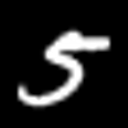
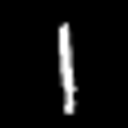

In [41]:
img_data2 = x_train[8]

with Image.frombytes('L', size=(28, 28), data=img_data2) as img2:
    img2 = img2.resize((config.sample_size, config.sample_size))
    image_offsets2 = xp_array_to_gpu(generate_image_offsets(np.array(img2).ravel(), xy_offsets))

image_offset_encodings2 = xp_array_from_gpu(sense_images(image_offsets2))
assert image_offset_encodings2.shape == (image_offsets2.shape[0], SENSORS_COUNT)
display_images([img, img2])

In [42]:
hdvs_other_old = []

for image_offset_encoding in tqdm(image_offset_encodings2):
    hdvs_other_old.append(encoding_to_hdv(image_offset_encoding))

hdvs_other_old = np.array(hdvs_other_old)
hdvs_other_old = hdc.normalize(hdvs_other_old)
cross_sim = hdvs_old @ hdvs_other_old.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

count    406.000000
mean       0.085390
std        0.017178
min        0.040363
25%        0.073196
50%        0.085082
75%        0.096231
max        0.132567
dtype: float64

In [43]:
%%time
hdvs_other_new = []

for image_offset_encoding in tqdm(image_offset_encodings2):
    normal_map = encoding_to_normal_map(image_offset_encoding)
    image_offset_encoding = normal_map_to_encoding(normal_map)
    hdvs_other_new.append(encoding_to_hdv(image_offset_encoding))

hdvs_other_new = np.array(hdvs_other_new)
hdvs_other_new = hdc.normalize(hdvs_other_new)
cross_sim = hdvs_new @ hdvs_other_new.T
cross_sim = cross_sim[np.tril_indices(cross_sim.shape[0], -1)] # exclude dups and self cross sims
pd.Series(cross_sim).describe()

  0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 899 ms, sys: 7.16 ms, total: 906 ms
Wall time: 564 ms


count    406.000000
mean       0.283100
std        0.018022
min        0.229569
25%        0.271144
50%        0.282990
75%        0.296858
max        0.334949
dtype: float64

# Tables 'images', 'image_encodings', 'image_encoding_hdv_bundles'

In [44]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)

    if config.encoding_type == 'exnormal':
        xy_offsets = [[0, 0]]
    else:
        xy_offsets_grid = get_grid_offsets(-2, 2)
        xy_offsets_clock = get_clock_offsets([5, 3])
        xy_offsets = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(xy_offsets_grid, xy_offsets_clock)))))
        xy_offsets = np.concat([[[0, 0]], xy_offsets])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets)) # 98% of time consumes this call! mp.Pool can't speed up create_dataset =(
            
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                if config.encoding_type == 'exnormal':
                    normal_map = encoding_to_normal_map(xp_array_from_gpu(ioe))
                    ioe = normal_map_to_encoding(normal_map).astype('b')
                else:
                    ioe = xp_array_from_gpu(ioe).astype('b')

                for column_id in range(-1, config.cortical_columns_count): # -1 is used to store original encoding
                    image_encoding_dataset['image_id'].append(image_id)
                    image_encoding_dataset['column_id'].append(column_id)
                    image_encoding_dataset['offset_x'].append(x)
                    image_encoding_dataset['offset_y'].append(y)

                    if column_id == -1:
                        image_encoding_dataset['encoding'].append(ioe)
                    else:
                        column_rec_field = CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id]
                        assert column_rec_field.shape == ioe.shape
                        column_ioe = ioe * column_rec_field # masking
                        image_encoding_dataset['encoding'].append(column_ioe)
    
    image_dataset = pd.DataFrame(image_dataset)
    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)
    image_encoding_dataset.to_sql(name='image_encodings', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id ON image_encodings(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_column_id ON image_encodings(column_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id_column_id ON image_encodings(image_id, column_id)')
    cur.execute('ALTER TABLE image_encodings ADD COLUMN hdv BLOB')
    db_con.commit()

In [45]:
%%time
train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
    if not is_table_exists(db_con, 'images'):
        image_dataset, image_encoding_dataset = create_datasets(x, y, samples_count, id_offset)
        save_datasets(image_dataset, image_encoding_dataset, db_con)

CPU times: user 7.55 ms, sys: 985 μs, total: 8.54 ms
Wall time: 1.69 ms


In [46]:
# %%time
# train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
# test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

# for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
#     drop_table_safe(db_con, 'image_encodings')
#     drop_table_safe(db_con, 'image_encoding_hdv_bundles')
#     drop_table_safe(db_con, 'images')
#     db_con.commit()

In [48]:
%%time

def is_any_hdv_missing(db_con):
    cur = db_con.cursor() 
    rows = cur.execute('SELECT 1 FROM image_encodings WHERE (hdv IS NULL OR LENGTH(hdv)<>:hdv_N) LIMIT 1', {'hdv_N': config.hdc_n}).fetchall()
    return len(rows) > 0

def mp_encoding_to_hdv(task):
    enc_index, encoding = task
    encoding_hdv = encoding_to_hdv(encoding)
    return (enc_index, encoding_hdv)

def make_image_encoding_hdvs(db_con):
    df_image_encodings = pd.read_sql('SELECT "index", encoding FROM image_encodings WHERE (hdv IS NULL OR LENGTH(hdv)<>:hdv_N)', params={'hdv_N': config.hdc_n}, con=db_con)
    batch_size = max(4, mp.cpu_count() - 1)

    def run_pending_tasks(async_task_results, new_tasks, is_drain=False):
        cycles = 2 if is_drain else 1

        for _ in range(cycles):
            task_results = async_task_results.get() if async_task_results else None
            async_task_results = pool.map_async(mp_encoding_to_hdv, new_tasks) if new_tasks else None
            new_tasks = None
    
            if task_results:
                # While new tasks are being executed we persist data from previous run (interleaved CPU and IO tasks)
                executemany_params = list(map(lambda tr: {'index': tr[0], 'hdv': tr[1].tobytes()}, task_results))
                cur.executemany('UPDATE image_encodings SET hdv=:hdv WHERE "index"=:index', executemany_params)
                db_con.commit()
    
        return async_task_results
    
    with mp.Pool(processes=batch_size) as pool:
        cur = db_con.cursor()
        async_task_result = None
        tasks = []

        for _, enc_row in tqdm(df_image_encodings.iterrows(), total=len(df_image_encodings)):
            enc_index = int(enc_row['index'])
            encoding = np.frombuffer(enc_row['encoding'], dtype='b')
            tasks.append((enc_index, encoding))

            if len(tasks) >= batch_size:
                async_task_result = run_pending_tasks(async_task_result, tasks)
                tasks = []

        # Complete pending tasks and drain remaining
        run_pending_tasks(async_task_result, tasks, is_drain=True)
                

for db_con in [train_db_con, test_db_con]:
    if is_any_hdv_missing(db_con):
        make_image_encoding_hdvs(db_con)

CPU times: user 85.8 ms, sys: 128 ms, total: 214 ms
Wall time: 212 ms


In [48]:
%%time

for db_con in [train_db_con, test_db_con]:
    if not is_table_exists(db_con, 'image_encoding_hdv_bundles'):
        cur = db_con.cursor()
        cur.execute('CREATE TABLE image_encoding_hdv_bundles(image_id INTEGER, column_id INTEGER, hdv_bundle TEXT)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_image_id ON image_encoding_hdv_bundles(image_id)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_column_id ON image_encoding_hdv_bundles(column_id)')
        cur.execute('CREATE UNIQUE INDEX ix_image_encoding_hdv_bundles_image_id_column_id ON image_encoding_hdv_bundles(image_id, column_id)')
        db_con.commit()

    df_image_wo_bundles = pd.read_sql('SELECT i.image_id FROM images i LEFT JOIN image_encoding_hdv_bundles b ON i.image_id=b.image_id WHERE b.image_id IS NULL', con=db_con)

    if len(df_image_wo_bundles) == 0:
        continue
    
    executemany_params = []

    for image_id in tqdm(df_image_wo_bundles['image_id']):
        df_hdvs = pd.read_sql('SELECT column_id, hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': image_id}, con=db_con)
        
        for column_id in df_hdvs['column_id'].unique():
            column_id = int(column_id)
            hdvs = df_hdvs.loc[df_hdvs['column_id'] == column_id]['hdv']
            hdvs = list(map(lambda hdv: np.frombuffer(hdv, dtype='b'), hdvs))
            hdv_bundle = hdc.bundle(hdvs)
            executemany_params.append({'image_id': image_id, 'column_id': column_id, 'hdv_bundle': hdv_bundle.tobytes()})
        
    cur = db_con.cursor()
    cur.executemany('INSERT INTO image_encoding_hdv_bundles (image_id, column_id, hdv_bundle) VALUES (:image_id, :column_id, :hdv_bundle)', executemany_params)
    db_con.commit()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 58.3 s, sys: 2.5 s, total: 1min
Wall time: 1min


In [53]:
df_image_encodings = pd.read_sql('SELECT "index", hdv FROM image_encodings WHERE "index"=0 LIMIT 1', con=train_db_con)

for enc_index, enc_row in df_image_encodings.iterrows():
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    assert hdv.shape[0] == hdc.N
    print(len(enc_row['hdv']), hdv.shape, np.unique_counts(hdv))    

10000 (10000,) UniqueCountsResult(values=array([-1,  0,  1], dtype=int8), counts=array([5113,  281, 4606]))


CPU times: user 348 ms, sys: 31 ms, total: 379 ms
Wall time: 377 ms



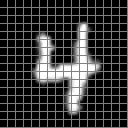
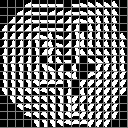
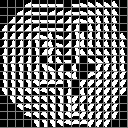

In [56]:
%%time
empty_image = Image.new('L', size=(1,1), color=255)
images = []
captions = []
col_count = 8

df_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
image_id = RNG.choice(df_images.index.unique())
image_id = 11670
image_data = df_images.loc[image_id]['png']
image = Image.open(io.BytesIO(image_data))
images.append(image)
captions.append(f'{image_id}, val={df_images.loc[image_id]['value']}')
images.extend([empty_image] * (col_count - 1))
captions.extend([''] * (col_count - 1))

column_id = -1
df_encodings = pd.read_sql_query('SELECT encoding, offset_x, offset_y, hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                 params={'image_id': int(image_id), 'column_id': column_id}, 
                                 con=train_db_con)
sz = config.sample_size
encodings = []
bundle_layers = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)
    encoding_dims = encoding.shape[0]
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    layers = []

    for sensor_group_index, sensor_group in enumerate(encoding):
        assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
        speficic_samples_reactions_for_sensor_group = SPECIFIC_SAMPLES_ENCODINGS[sensor_group_index]
        
        if np.any(sensor_group > 0):
            # Find most similar reaction among specific samples of reactions for given sensor group
            a = np.zeros(encoding_dims)
            assert a.shape[0] == speficic_samples_reactions_for_sensor_group.shape[1]
            a[sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE] = sensor_group
            a = a / np.linalg.norm(a)
            b = speficic_samples_reactions_for_sensor_group
            b = (b.T / np.linalg.norm(b, axis=1)).T
            cos_sim = (a @ b.T)
            best_i = np.argmax(cos_sim)
            most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
            assert most_similar_specific_sample.shape == (sz, sz)
            layers.append(most_similar_specific_sample)
            bundle_layers.append(most_similar_specific_sample)

    sensor_map_image = np.zeros((sz, sz))
    
    for layer in layers:
        sensor_map_image += layer

    sensor_map_image[sensor_map_image != 0] = 255
    images.append(Image.frombytes('L', (sz, sz), data=sensor_map_image.ravel().astype('b')))
    captions.append(f'offset={enc_row['offset_x']}, {enc_row['offset_y']}')

bundle_sensor_map_image = np.zeros((sz, sz))
    
for layer in bundle_layers:
    bundle_sensor_map_image += layer

bundle_sensor_map_image[bundle_sensor_map_image != 0] = 255
images[1] = matrix_to_image(bundle_sensor_map_image)
captions[1] = 'bundle'

lay_grid_local = lambda i: lay_grid(i, 8)
display_images_grid(list(map(lay_grid_local, images)), captions=captions, col_count=col_count)

In [51]:
encodings = []
encoding_dims = 0
hdvs = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)

    if encoding_dims:
        assert encoding_dims == encoding.shape[0]
    else:
        encoding_dims = encoding.shape[0]
        
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    hdvs.append(hdv)

hdvs_bundle1 = hdc.bundle(hdvs) # 1) bundle horizontally (all strides within each encoding) 2) bundle vertically (all enconding bundles)

assert encoding_dims > 0
stride_encoding_hdvs_bundles = []

for stride_index in range(0, encoding_dims, SENSOR_GROUP_SQUARE):
    stride_encoding_hdvs = []
    
    for encoding in encodings:
        stride = encoding[stride_index:stride_index + SENSOR_GROUP_SQUARE]
        stride_code = ''.join(map(str, stride.tolist()))

        if not stride_code.replace('0', ''): # for relatively short strides this is ~x2 faster than np.all(stride == 0) or np.max(stride) == 0
            continue

        assert stride_code in STRIDE_HDVS
        stride_hdv = STRIDE_HDVS[stride_code]
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        stride_encoding_hdvs.append(stride_hdv)

    if stride_encoding_hdvs:
        stride_encoding_hdvs_bundle = hdc.bundle(stride_encoding_hdvs)
        stride_encoding_hdvs_bundles.append(stride_encoding_hdvs_bundle)

hdvs_bundle2 = hdc.bundle(stride_encoding_hdvs_bundles) # 1) bundle vertically (all strides with the same indices) 2) bundle horizontally (all stride bundles)
hdc.sim(hdvs_bundle1, hdvs_bundle2)

np.float64(1.0)